## Starfysh tutorial

#### Azizi Lab

Siyu He, Yinuo Jin

08-05-2022

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context

In [3]:
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})

# Mute warning, TODO: manually fix the adata warnings (mostly due to "modification on copy" or version 
import warnings
warnings.filterwarnings('ignore')

### load starfysh

In [4]:
sys.path.append('../')
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      dataloader,
                      post_analysis,
                      AA
                      )

#### (1). load data and gene signature

In [5]:
# set the data folder
if IN_COLAB:
    data_folder = '/content/drive/MyDrive/SpatialModelProject/data'
else:
    data_folder = '../data/'
    #data_folder = 'simu_data'


In [34]:
%ls ../data

bc_signatures_version_0201.csv  MBC_1A/  MBC_2A/  MBC_3A/  MBC_4A/  README.md
CID44971/                       MBC_1B/  MBC_2B/  MBC_3B/  MBC_4B/  simu_3.zip


In [6]:
# sample_id='CID44971' # , CID44971, CID4465, CID4290, CID4535, 1142243F, 1160920F
sample_id = 'MBC_2A'
sig_file_name = 'bc_signatures_version_0201.csv'

adata_sample, adata_sample_normed = utils.load_adata(data_folder,sample_id,n_genes=2000)
gene_sig = pd.read_csv(os.path.join(data_folder,sig_file_name))

## filter the low expressed genes
gene_sig = utils.filter_gene_sig(gene_sig,adata_sample.to_df())

[2022-08-23 14:22:56] Preprocessing1: delete the mt and rp
[2022-08-23 14:22:57] Preprocessing2: Normalize
[2022-08-23 14:22:57] Preprocessing3: Logarithm
[2022-08-23 14:22:57] Preprocessing4: Find the variable genes


In [7]:
if data_folder =='simu_data':
    member = pd.read_csv(os.path.join(data_folder,sample_id,'members.st_synth.csv'),index_col=0)
    proportions = pd.read_csv(os.path.join(data_folder,sample_id,'proportions.st_synth.csv'),index_col=0)
    gene_sig = gene_sig.iloc[:,[1,3,4,7,8]]
    gene_sig.columns=['CAFs','Normal Epithelial','Myeloid','T-cells','Cancer Epithelial']
    gene_sig = gene_sig.reindex(columns=['CAFs','Cancer Epithelial','Myeloid','Normal Epithelial','T-cells'])

#### (2). Preprocessing & finding anchor spots.

In [8]:
if data_folder =='simu_data':
    umap_df = utils.get_umap(adata_sample)
    map_info = utils.get_simu_map_info(umap_df)
else:
    #adata_image, adata_image_h, adata_image_e,map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)
    adata_image, map_info = utils.preprocess_img(data_folder,sample_id,adata_sample.obs.index,hchannal=False)


Preparing arguments for model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)


In [9]:
# Preparing arguments for model training
visium_args = utils.VisiumArguments(adata_sample,
                                    adata_sample_normed,
                                    gene_sig,
                                    map_info,
                                    n_anchors=60,
                                    window_size=5
                                   )


[2022-08-23 14:23:04] Filtering signatures not highly variable...


	 The number of original variable genes in the dataset (2001,)
	 The number of siganture genes in the dataset (691,)
	 After filter out some genes in the signature not in the var_names ... (660,)
	 After filter out some genes not highly expressed in the signature ... (655,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537
	 The number of original variable genes in the dataset (2001,)
	 The number of siganture genes in the dataset (691,)
	 After filter out some genes in the signature not in the var_names ... (660,)


[2022-08-23 14:23:04] Smoothing library size by taking averaging with neighbor spots...


	 After filter out some genes not highly expressed in the signature ... (655,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537


[2022-08-23 14:23:07] Retrieving & normalizing signature gene expressions...
[2022-08-23 14:23:08] Identifying anchor spots (highly expression of specific cell-type signatures)...


In [10]:
adata_sample, adata_sample_normed = visium_args.get_adata() # adata after preprocessing & taking highly-variable genes
anchors_df = visium_args.get_anchors() # anchor spot indices
anchors_df.head()

T_cells_c0_CD4+_CCR7  T_cells_c1_CD4+_IL7R  T_cells_c3_CD4+_Tfh_CXCL13  \
0                  2629                  2629                         860   
1                  2931                  2188                        2866   
2                  1194                   938                        2501   
3                  2188                  2648                        1524   
4                  1176                  1176                        2895   

   T_cells_c2_CD4+_T-regs_FOXP3  B_cells_Memory  B_cells_Naive    NK  \
0                          2501             373             62   569   
1                           286            2237           2080  2895   
2                          1524            2080           1004  1458   
3                          1462              62           1461  2317   
4                          2995            1461            856  2252   

   Macrophage_M1  Macrophage_M2  Endothelial  ...   cDC   pDC  \
0            856            856          607  ...  1374  1320   
1            634            634         1624  ...   860  1744   
2            288           1461         2001  ...  2245  3157   
3           1461            288         1932  ...   338  2317   
4           2080           2748         2074  ...  2107  2251   

   Terminal_exhaustion  Precursor_exhaustion  CAFs_MSC_iCAF-like  \
0                  548                  1802                 858   
1                 2185                  1258                1505   
2                 1681                  2074                  18   
3                 1625                   537                  12   
4                  495                  1837                 817   

   CAFs_myCAF-like  PVL_Differentiated  PVL_Immature  Normal_epithelial  \
0               18                2649           607               1624   
1              858                 607           548               3068   
2              607                  63          2649               2074   
3             2689                 548          2185               2112   
4              548                2185            63               1722   

   Plasmablasts  
0           433  
1           554  
2           809  
3          1592  
4          1642  

[5 rows x 26 columns]

In [11]:
# Signature mean expression (before & after z-normalization) at each spot
sig_means = visium_args.sig_mean
sig_mean_znorms = visium_args.sig_mean_znorm
sig_means.head()

T_cells_c0_CD4+_CCR7  T_cells_c1_CD4+_IL7R  \
AAACAATCTACTAGCA-1              4.257143              1.944444   
AAACACCAATAACTGC-1              7.428571              4.083333   
AAACAGCTTTCAGAAG-1              1.714286              1.055556   
AAACAGGGTCTATATT-1              5.142857              2.277778   
AAACAGTGTTCCTGGG-1              5.914286              3.361111   

                    T_cells_c3_CD4+_Tfh_CXCL13  T_cells_c2_CD4+_T-regs_FOXP3  \
AAACAATCTACTAGCA-1                    1.000000                      1.459459   
AAACACCAATAACTGC-1                    1.393939                      1.891892   
AAACAGCTTTCAGAAG-1                    1.000000                      1.486486   
AAACAGGGTCTATATT-1                    0.424242                      0.891892   
AAACAGTGTTCCTGGG-1                    0.515152                      0.432432   

                    B_cells_Memory  B_cells_Naive        NK  Macrophage_M1  \
AAACAATCTACTAGCA-1        5.676471       4.826087  0.787879       7.032258   
AAACACCAATAACTGC-1        5.500000       4.369565  1.696970       7.741935   
AAACAGCTTTCAGAAG-1       23.294117      18.826086  1.272727      17.048388   
AAACAGGGTCTATATT-1        2.088235       1.695652  0.939394       3.693548   
AAACAGTGTTCCTGGG-1        1.735294       1.565217  1.212121       2.596774   

                    Macrophage_M2  Endothelial  ...       cDC           pDC  \
AAACAATCTACTAGCA-1       7.620690     1.821429  ...  0.250000  3.750000e-01   
AAACACCAATAACTGC-1       9.258620     7.678571  ...  0.083333  1.125000e+00   
AAACAGCTTTCAGAAG-1      18.396551     2.553571  ...  0.666667  3.750000e-01   
AAACAGGGTCTATATT-1       4.327586     4.446429  ...  0.166667  1.000000e-12   
AAACAGTGTTCCTGGG-1       3.879310     5.339286  ...  0.500000  5.000000e-01   

                    Terminal_exhaustion  Precursor_exhaustion  \
AAACAATCTACTAGCA-1             1.066667              2.619048   
AAACACCAATAACTGC-1             2.933333              7.142857   
AAACAGCTTTCAGAAG-1             1.233333              2.428571   
AAACAGGGTCTATATT-1             1.233333              4.190476   
AAACAGTGTTCCTGGG-1             2.466667              5.285714   

                    CAFs_MSC_iCAF-like  CAFs_myCAF-like  PVL_Differentiated  \
AAACAATCTACTAGCA-1            2.161290         3.096774            2.400000   
AAACACCAATAACTGC-1            4.516129         7.709677            4.766667   
AAACAGCTTTCAGAAG-1            3.967742         4.806452            1.600000   
AAACAGGGTCTATATT-1            2.451613         3.354839            2.766667   
AAACAGTGTTCCTGGG-1            1.516129         1.290323            2.866667   

                    PVL_Immature  Normal_epithelial  Plasmablasts  
AAACAATCTACTAGCA-1      2.100000           3.684211      5.222222  
AAACACCAATAACTGC-1      4.566667           7.684210     25.944445  
AAACAGCTTTCAGAAG-1      2.133333           1.394737     67.611115  
AAACAGGGTCTATATT-1      1.900000           6.921052     15.555555  
AAACAGTGTTCCTGGG-1      1.233333           7.789474      8.916667  

[5 rows x 26 columns]

#### (3). Spatial visualization of library size & gene expression

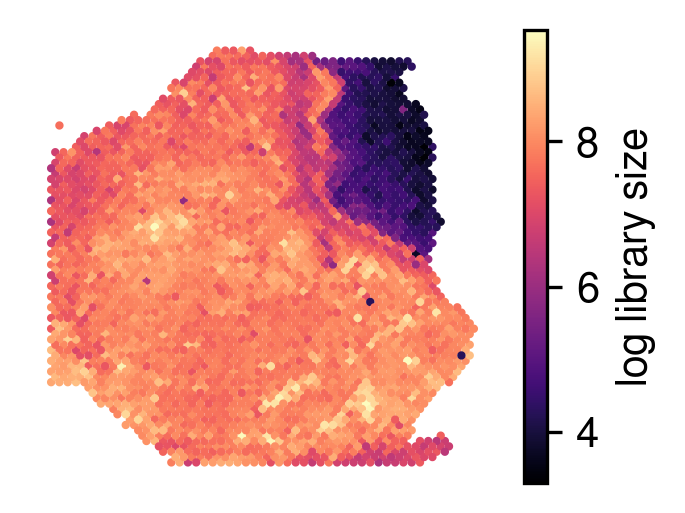

In [15]:
plot_utils.plot_spatial_var(map_info,
                            adata_sample,
                            visium_args.log_lib,
                            label='log library size'
                           )

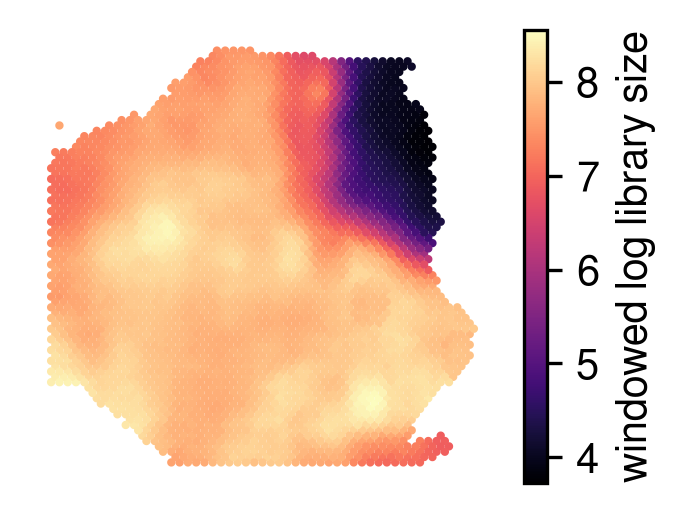

In [16]:
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 visium_args.win_loglib,
                 label='windowed log library size'
                )

plot raw gene expression:

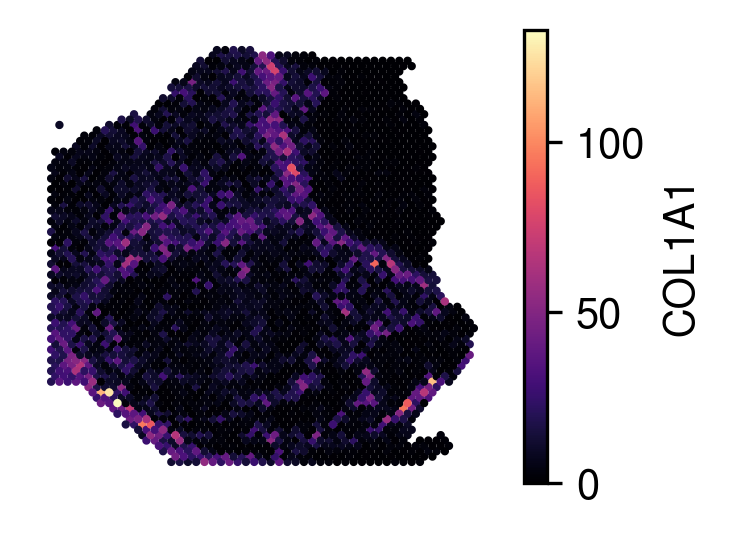

In [17]:
plot_gene_name = 'COL1A1'
plot_utils.plot_spatial_var(map_info,
                 adata_sample,
                 adata_sample.to_df().loc[:,plot_gene_name],
                 label=plot_gene_name
                )

Plot anchor spots:

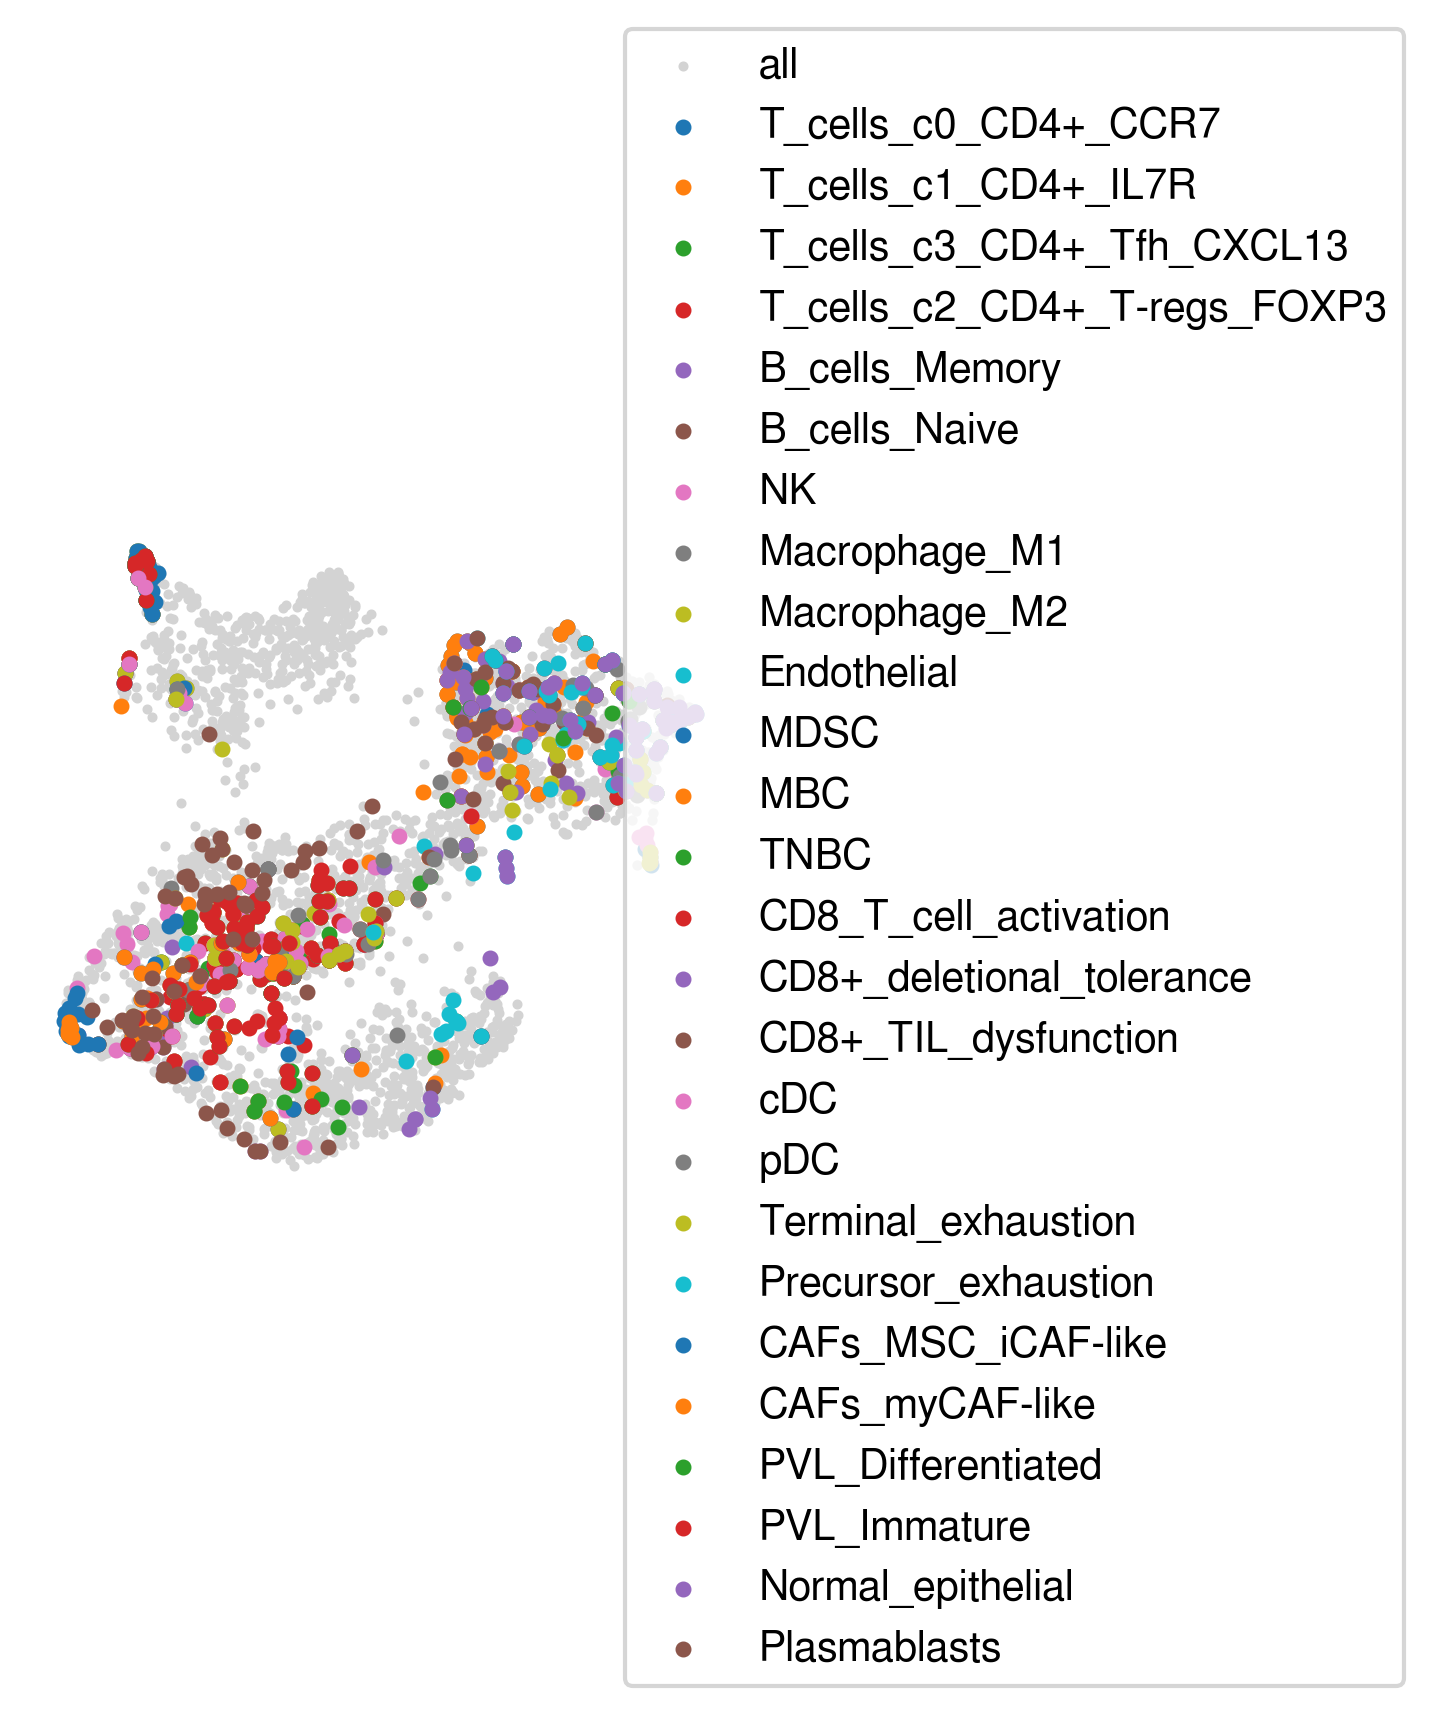

In [18]:
umap_df = utils.get_umap(adata_sample_normed)
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

#### (4). Optional: appending anchor spots with archetypal analysis

Tasks:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Find novel cell type / cell states as the most distant archetypes (Not close to any anchor spots of annotated cell types)

In [19]:
from starfysh.AA import ArchetypalAnalysis

[Note]<br>
Set `pc_ratio` $(0, 1)$ higher to find more # raw archetypes ($k$). If you encounter `NaN` errors when estimating $k$, please decrease `pc_ratio`.

First, we find major archetypal spots & marker genes:

In [22]:
aa_model = ArchetypalAnalysis(adata_orig=adata_sample_normed)
archetype, arche_dict, major_idx = aa_model.compute_archetypes(pc_ratio=.05, cn=None, display=False)


[2022-08-23 14:51:14] Computing intrinsic dimension to estimate k...


181 components are retained using conditional_number=126.85


[2022-08-23 14:51:16] Computing 56 archetypes...
[2022-08-23 14:58:16] Calculating UMAPs for counts + Archetypes...
[2022-08-23 14:58:36] Calculating UMAPs for counts + Archetypes...
[2022-08-23 14:58:54] 0.7397 variance explained by raw archetypes.
Merging those within 20 NNs to get major archetypes


In [30]:
# Find archetypal spots, major specifies whether find hierarchical archetypes
arche_df = aa_model.find_archetypal_spots(major=False)

# Find marker genes
markers_df = aa_model.find_markers(n_markers=30, display=False)

# Map archetypes to closest anchors (1-1 per cell type) 
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=5)

[2022-08-23 15:00:41] Finding 40 nearest neighbors for each archetype...
[2022-08-23 15:00:55] Finding 30 top marker genes for each archetype...
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


##### Visualize archetypes

- Hierarchical structure of archetypes (raw archetypes within certain mutual distance of `r` will shrink into major archetypes): 

In [32]:
aa_model.arche_dict

{0: array([ 0,  1,  2,  3, 12, 14, 17, 41, 46, 48, 49, 50]),
 4: array([ 4,  6,  7,  9, 11, 15, 19, 22, 26, 29, 32, 33, 34, 36, 37, 39, 45,
        47, 53]),
 5: array([ 5, 21, 28]),
 8: array([ 8, 38]),
 10: array([10, 18, 20, 24, 25, 27, 30, 44]),
 13: array([13, 16, 52, 54]),
 31: array([31, 42, 43]),
 40: array([40, 55])}

In [33]:
map_dict

{'T_cells_c0_CD4+_CCR7': 'arch_5',
 'T_cells_c1_CD4+_IL7R': 'arch_5',
 'T_cells_c3_CD4+_Tfh_CXCL13': 'arch_16',
 'T_cells_c2_CD4+_T-regs_FOXP3': 'arch_16',
 'B_cells_Memory': 'arch_13',
 'B_cells_Naive': 'arch_13',
 'NK': 'arch_16',
 'Macrophage_M1': 'arch_13',
 'Macrophage_M2': 'arch_52',
 'Endothelial': 'arch_1',
 'MDSC': 'arch_52',
 'MBC': 'arch_5',
 'TNBC': 'arch_13',
 'CD8_T_cell_activation': 'arch_16',
 'CD8+_deletional_tolerance': 'arch_2',
 'CD8+_TIL_dysfunction': 'arch_12',
 'cDC': 'arch_16',
 'Precursor_exhaustion': 'arch_41',
 'CAFs_MSC_iCAF-like': 'arch_23',
 'CAFs_myCAF-like': 'arch_23',
 'PVL_Differentiated': 'arch_35',
 'PVL_Immature': 'arch_8',
 'Normal_epithelial': 'arch_48'}

The dictionary above states that, archetypes `0, 1, 2 & 4` have their hierarchical structure, harboring more than one raw archetypes.

- Visualize archetypes in 3D UMAP:

(<Figure size 1800x1200 with 1 Axes>, <Axes3DSubplot:>)

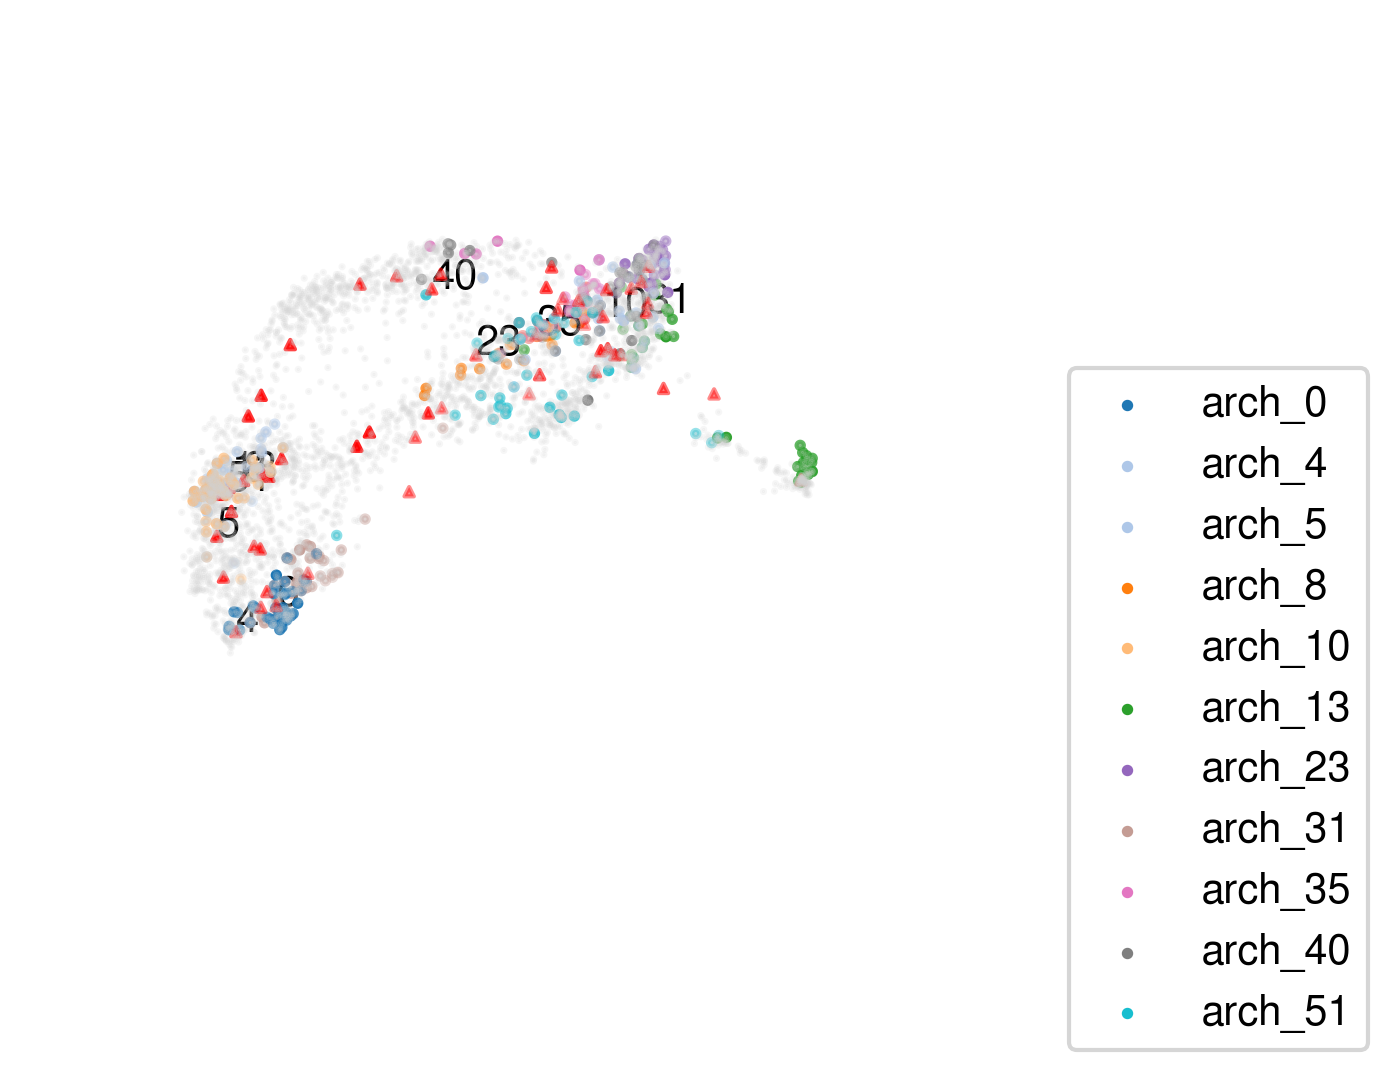

In [34]:
aa_model.plot_archetypes(do_3d=True)

- Juxtapose of anchor spots & archetypal spots:

(<Figure size 2700x900 with 2 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

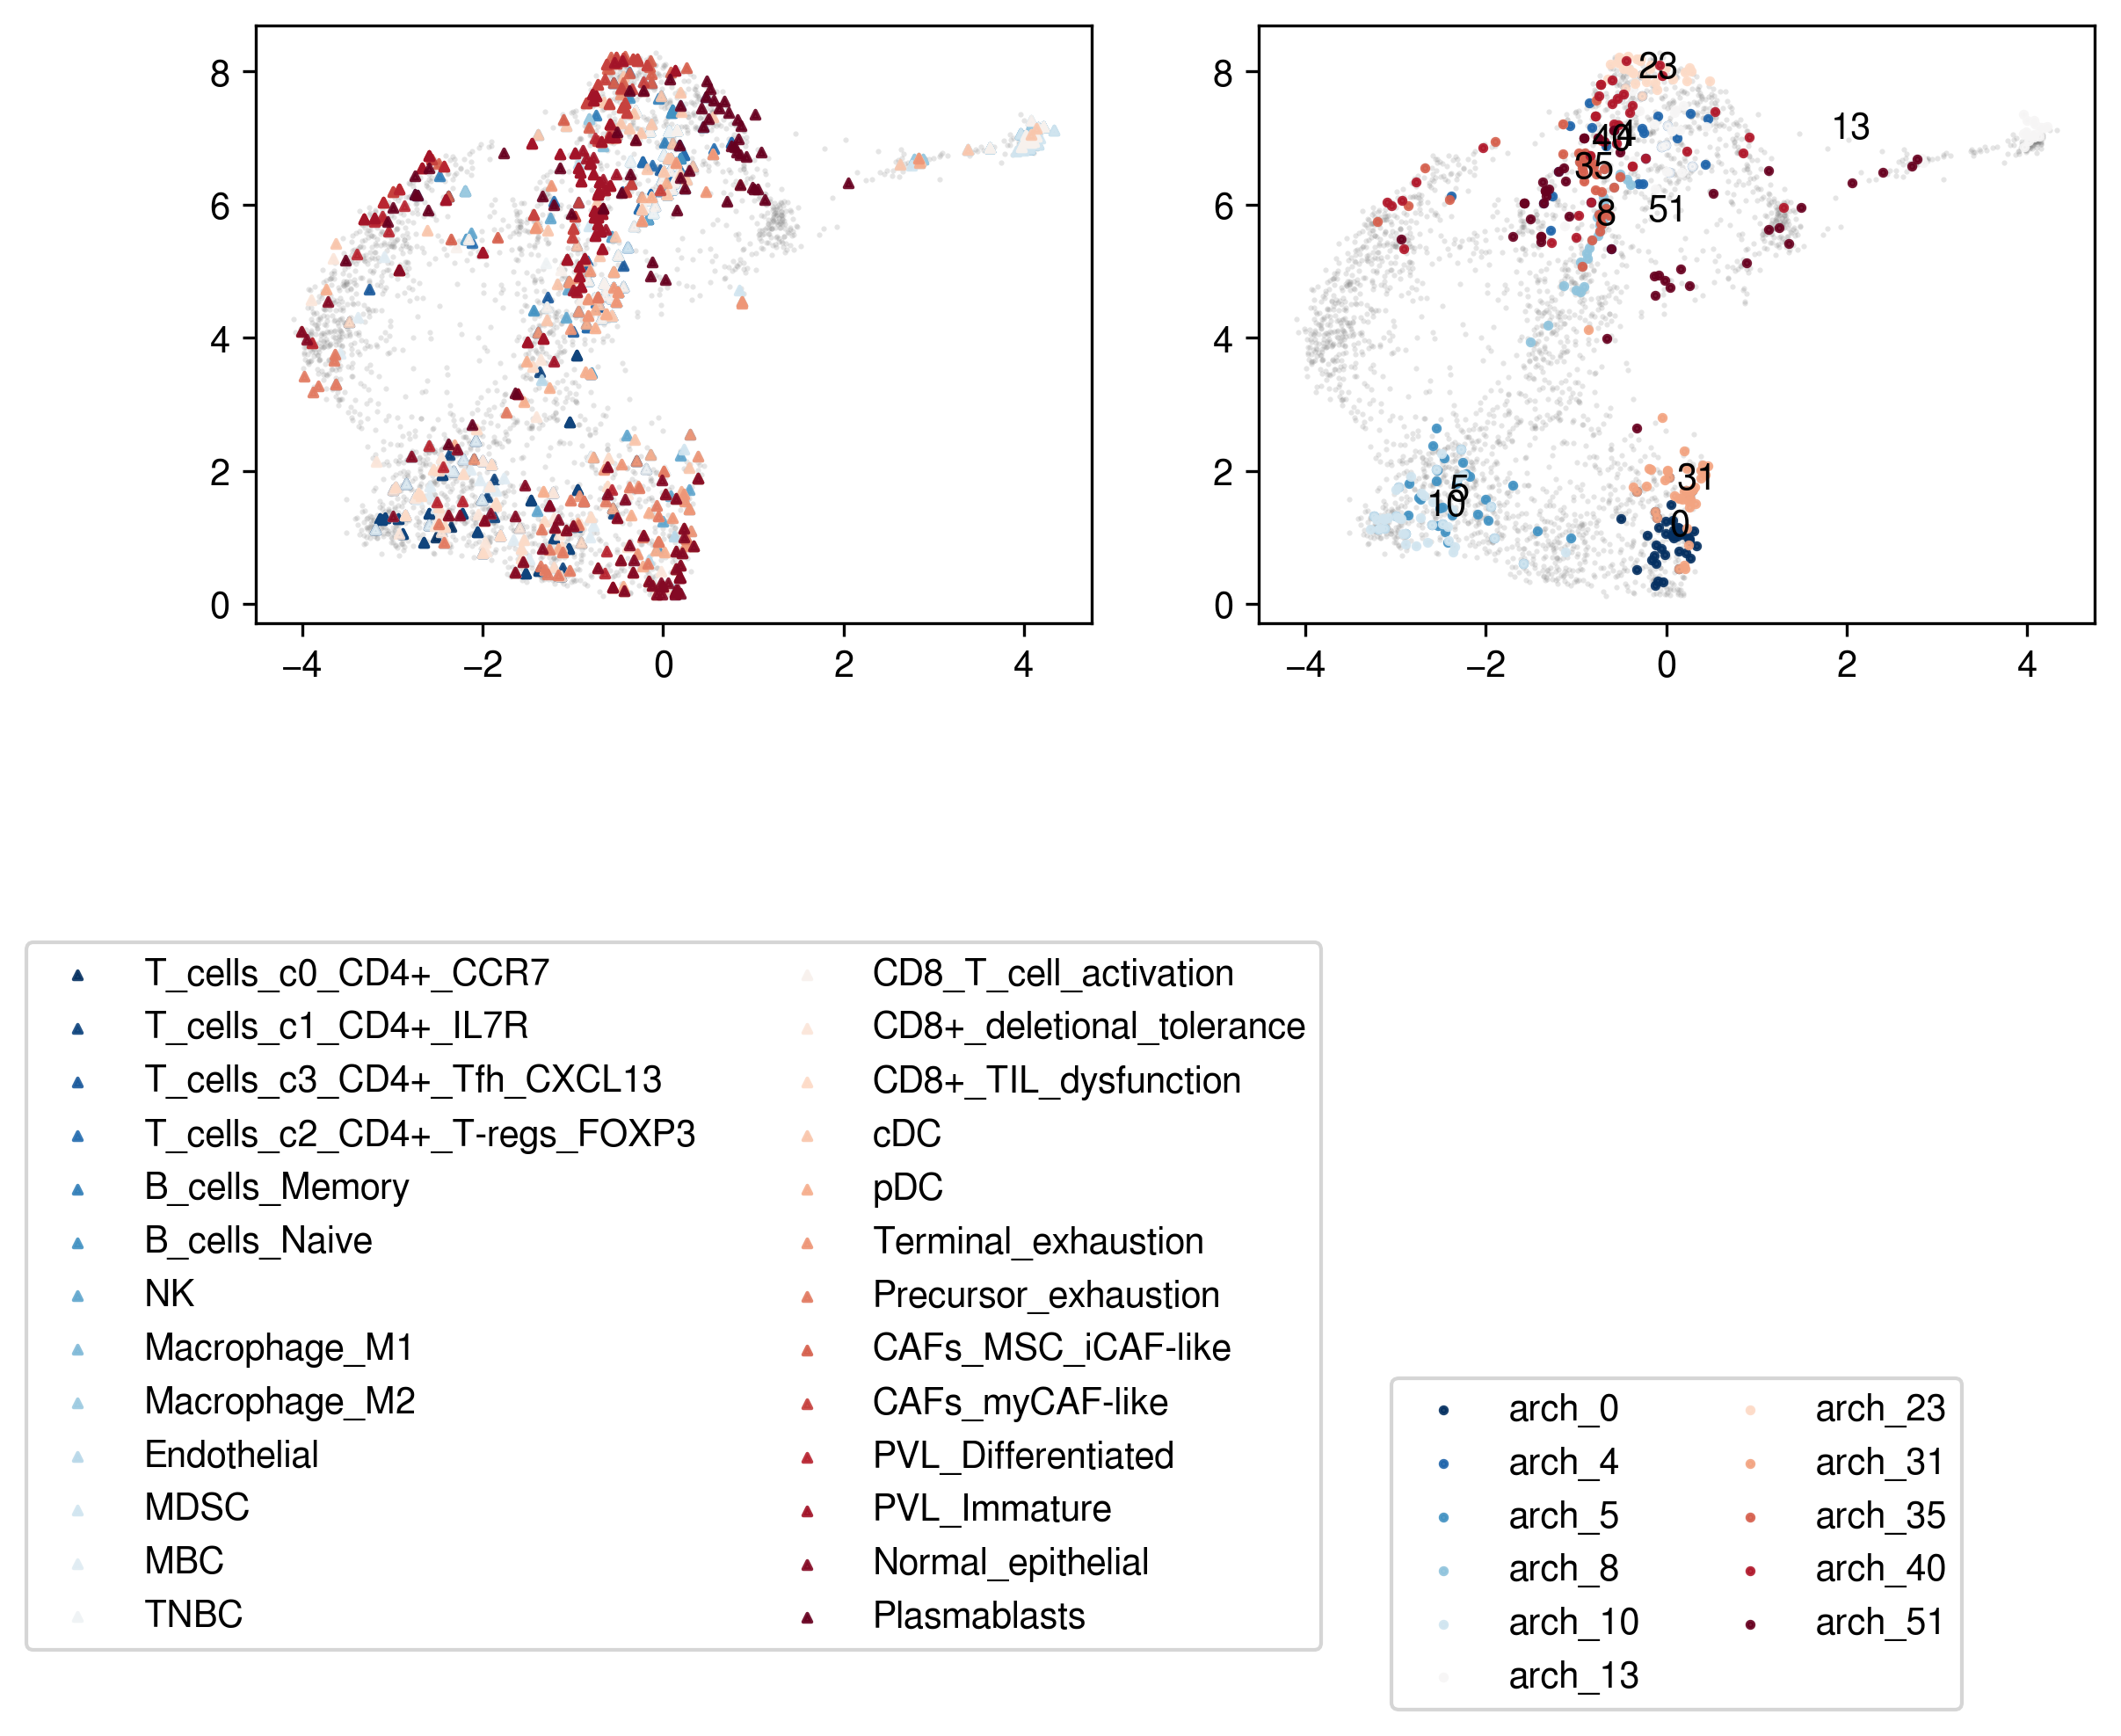

In [28]:
aa_model.plot_anchor_archetype_clusters(anchors_df)

- Visualize overlapping ratio between archetypal & anchor spots:

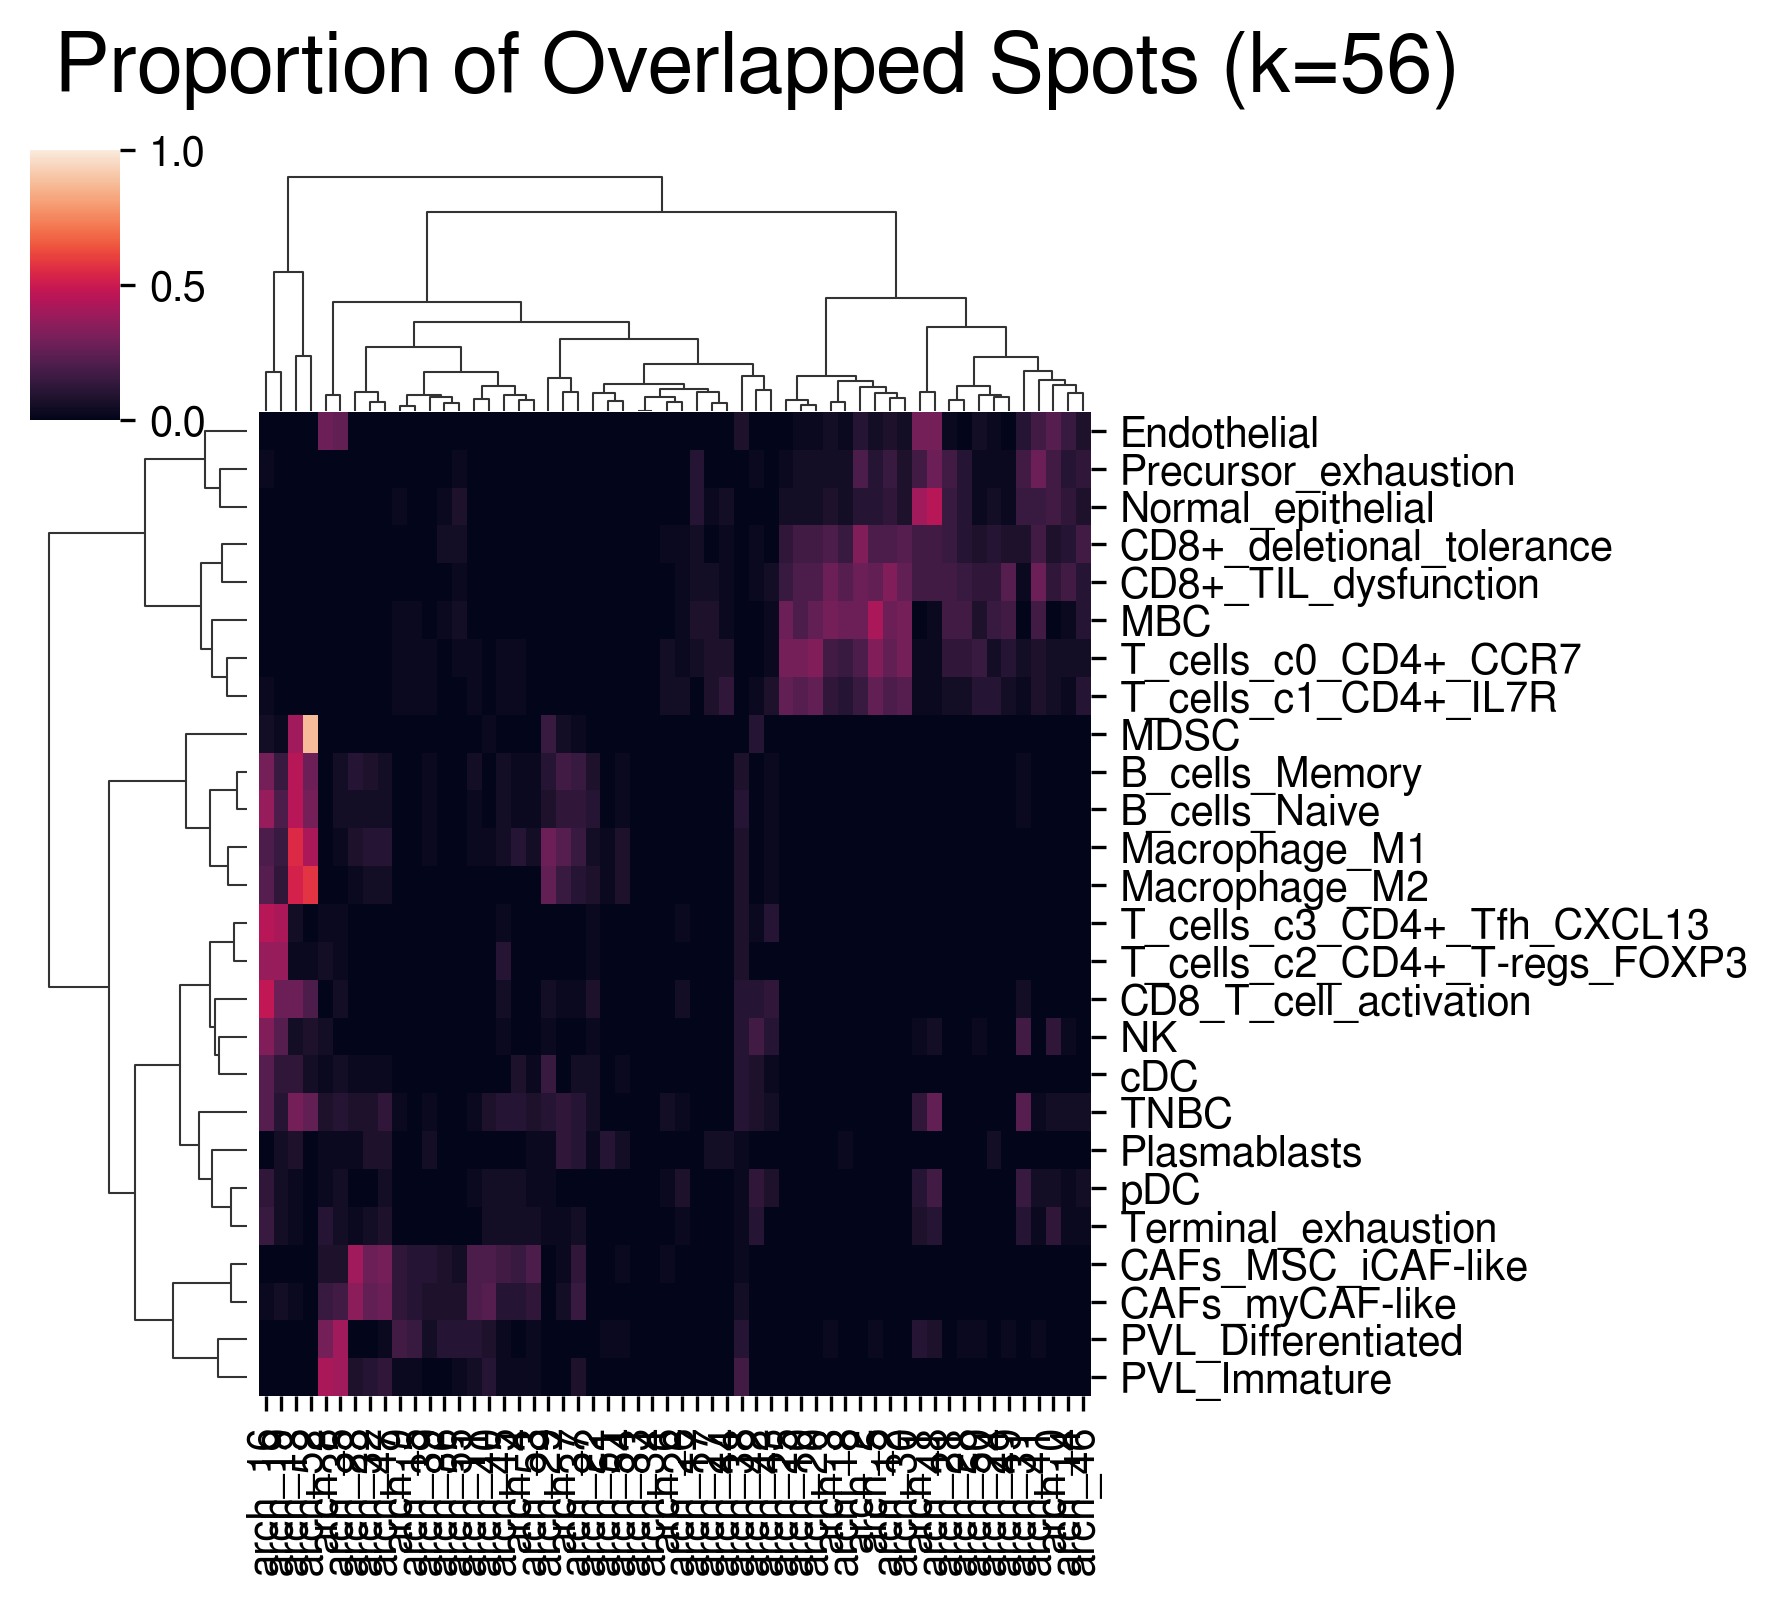

In [35]:
aa_model.plot_mapping(map_df)

- Visualize overlapping features between subset of anchors & archetypes: <br>
  E.g. `T-reg (FOXP3)` & `arch_16`; `MBC` & `arch_5`; `TNBC` & `arch_13`


(<Figure size 2700x900 with 2 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

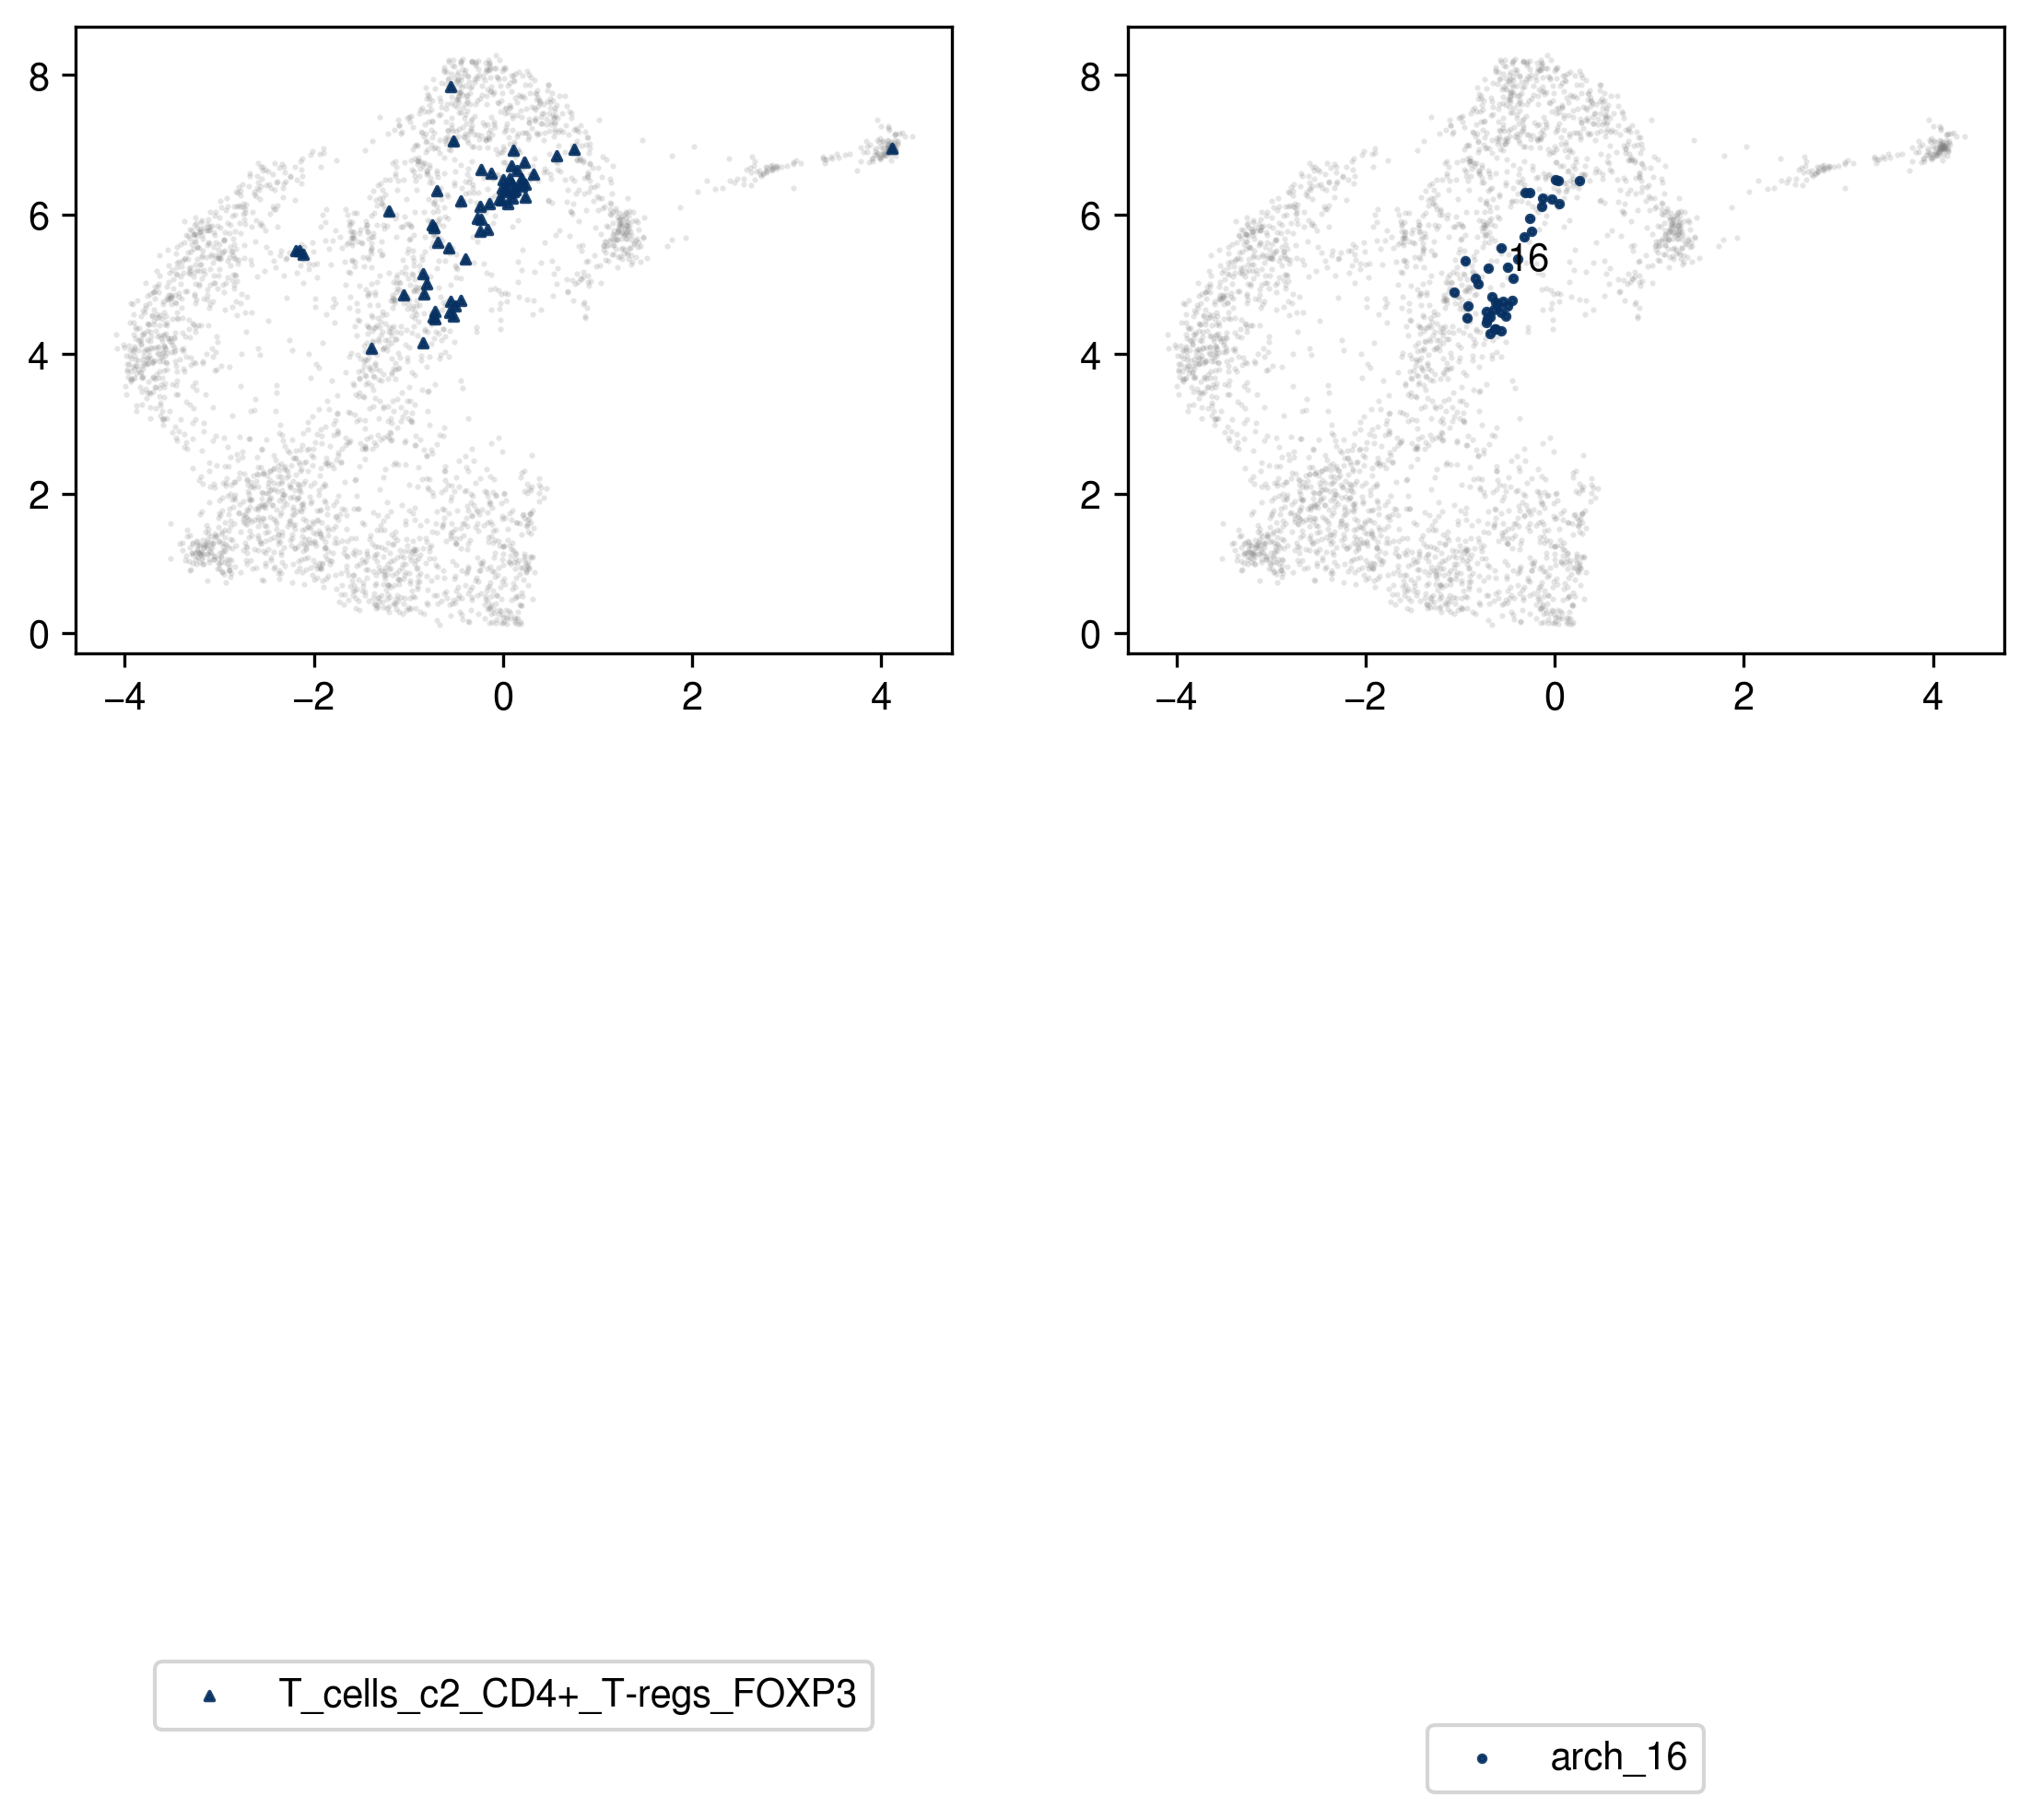

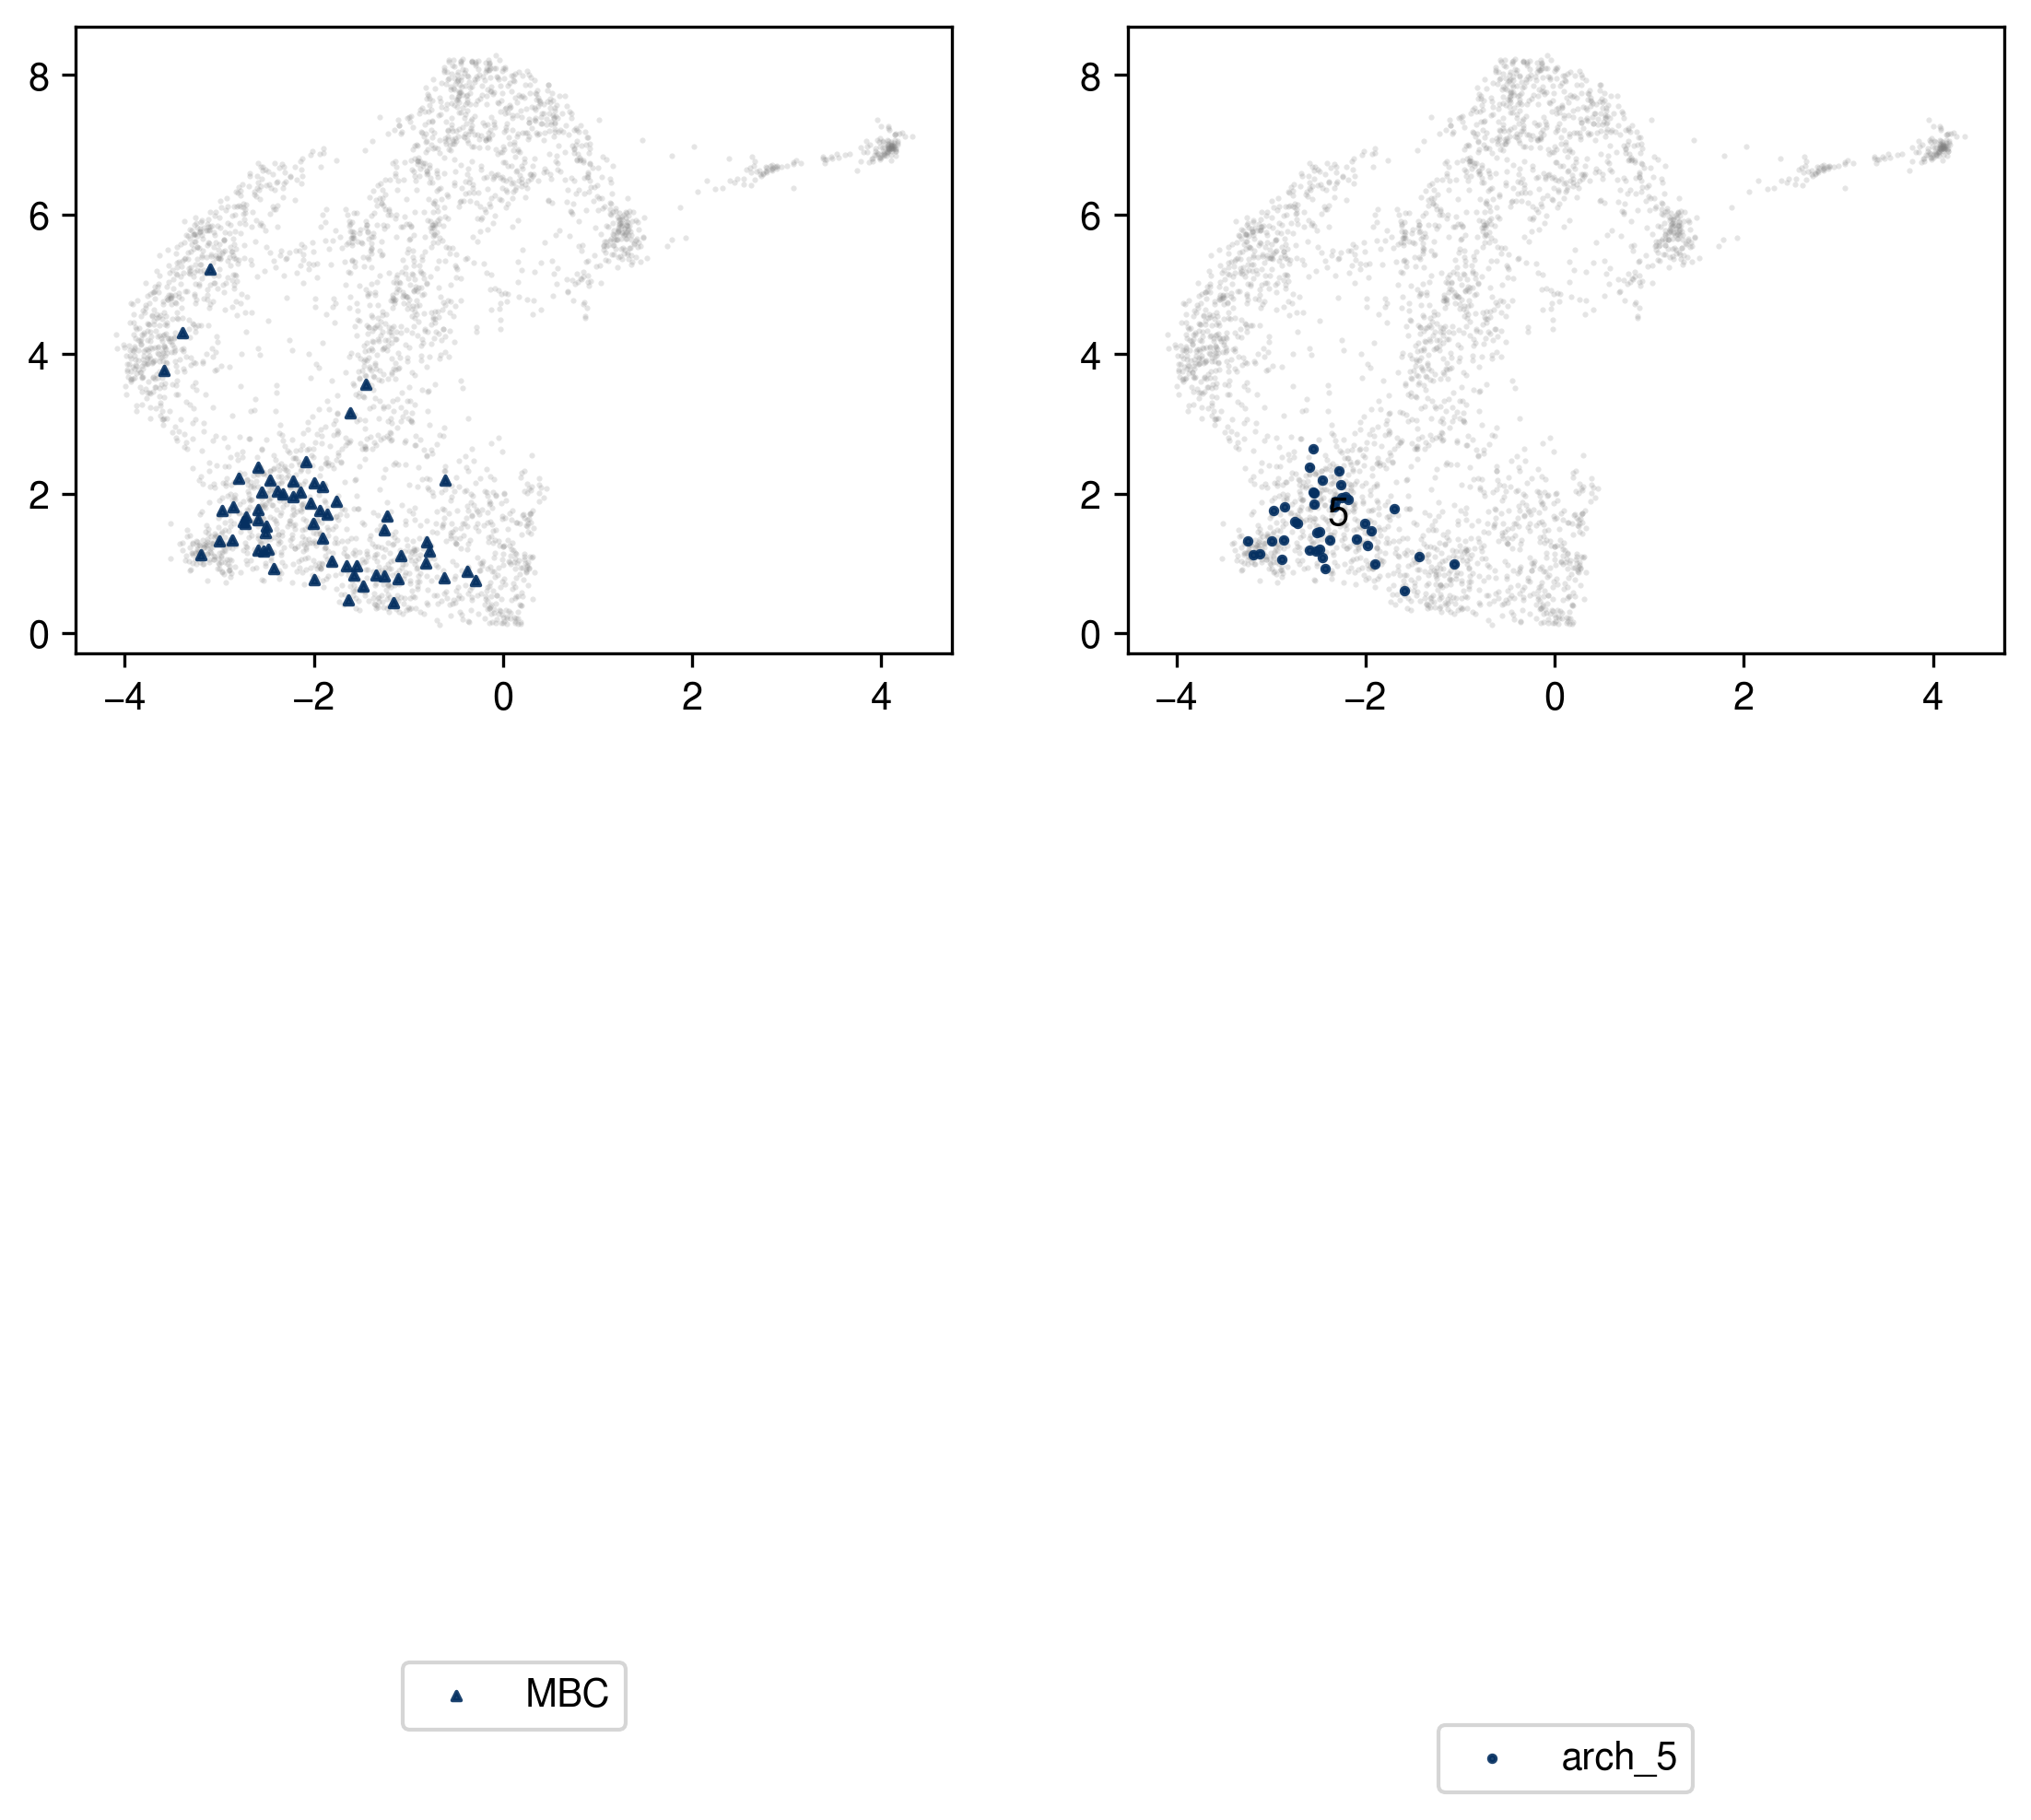

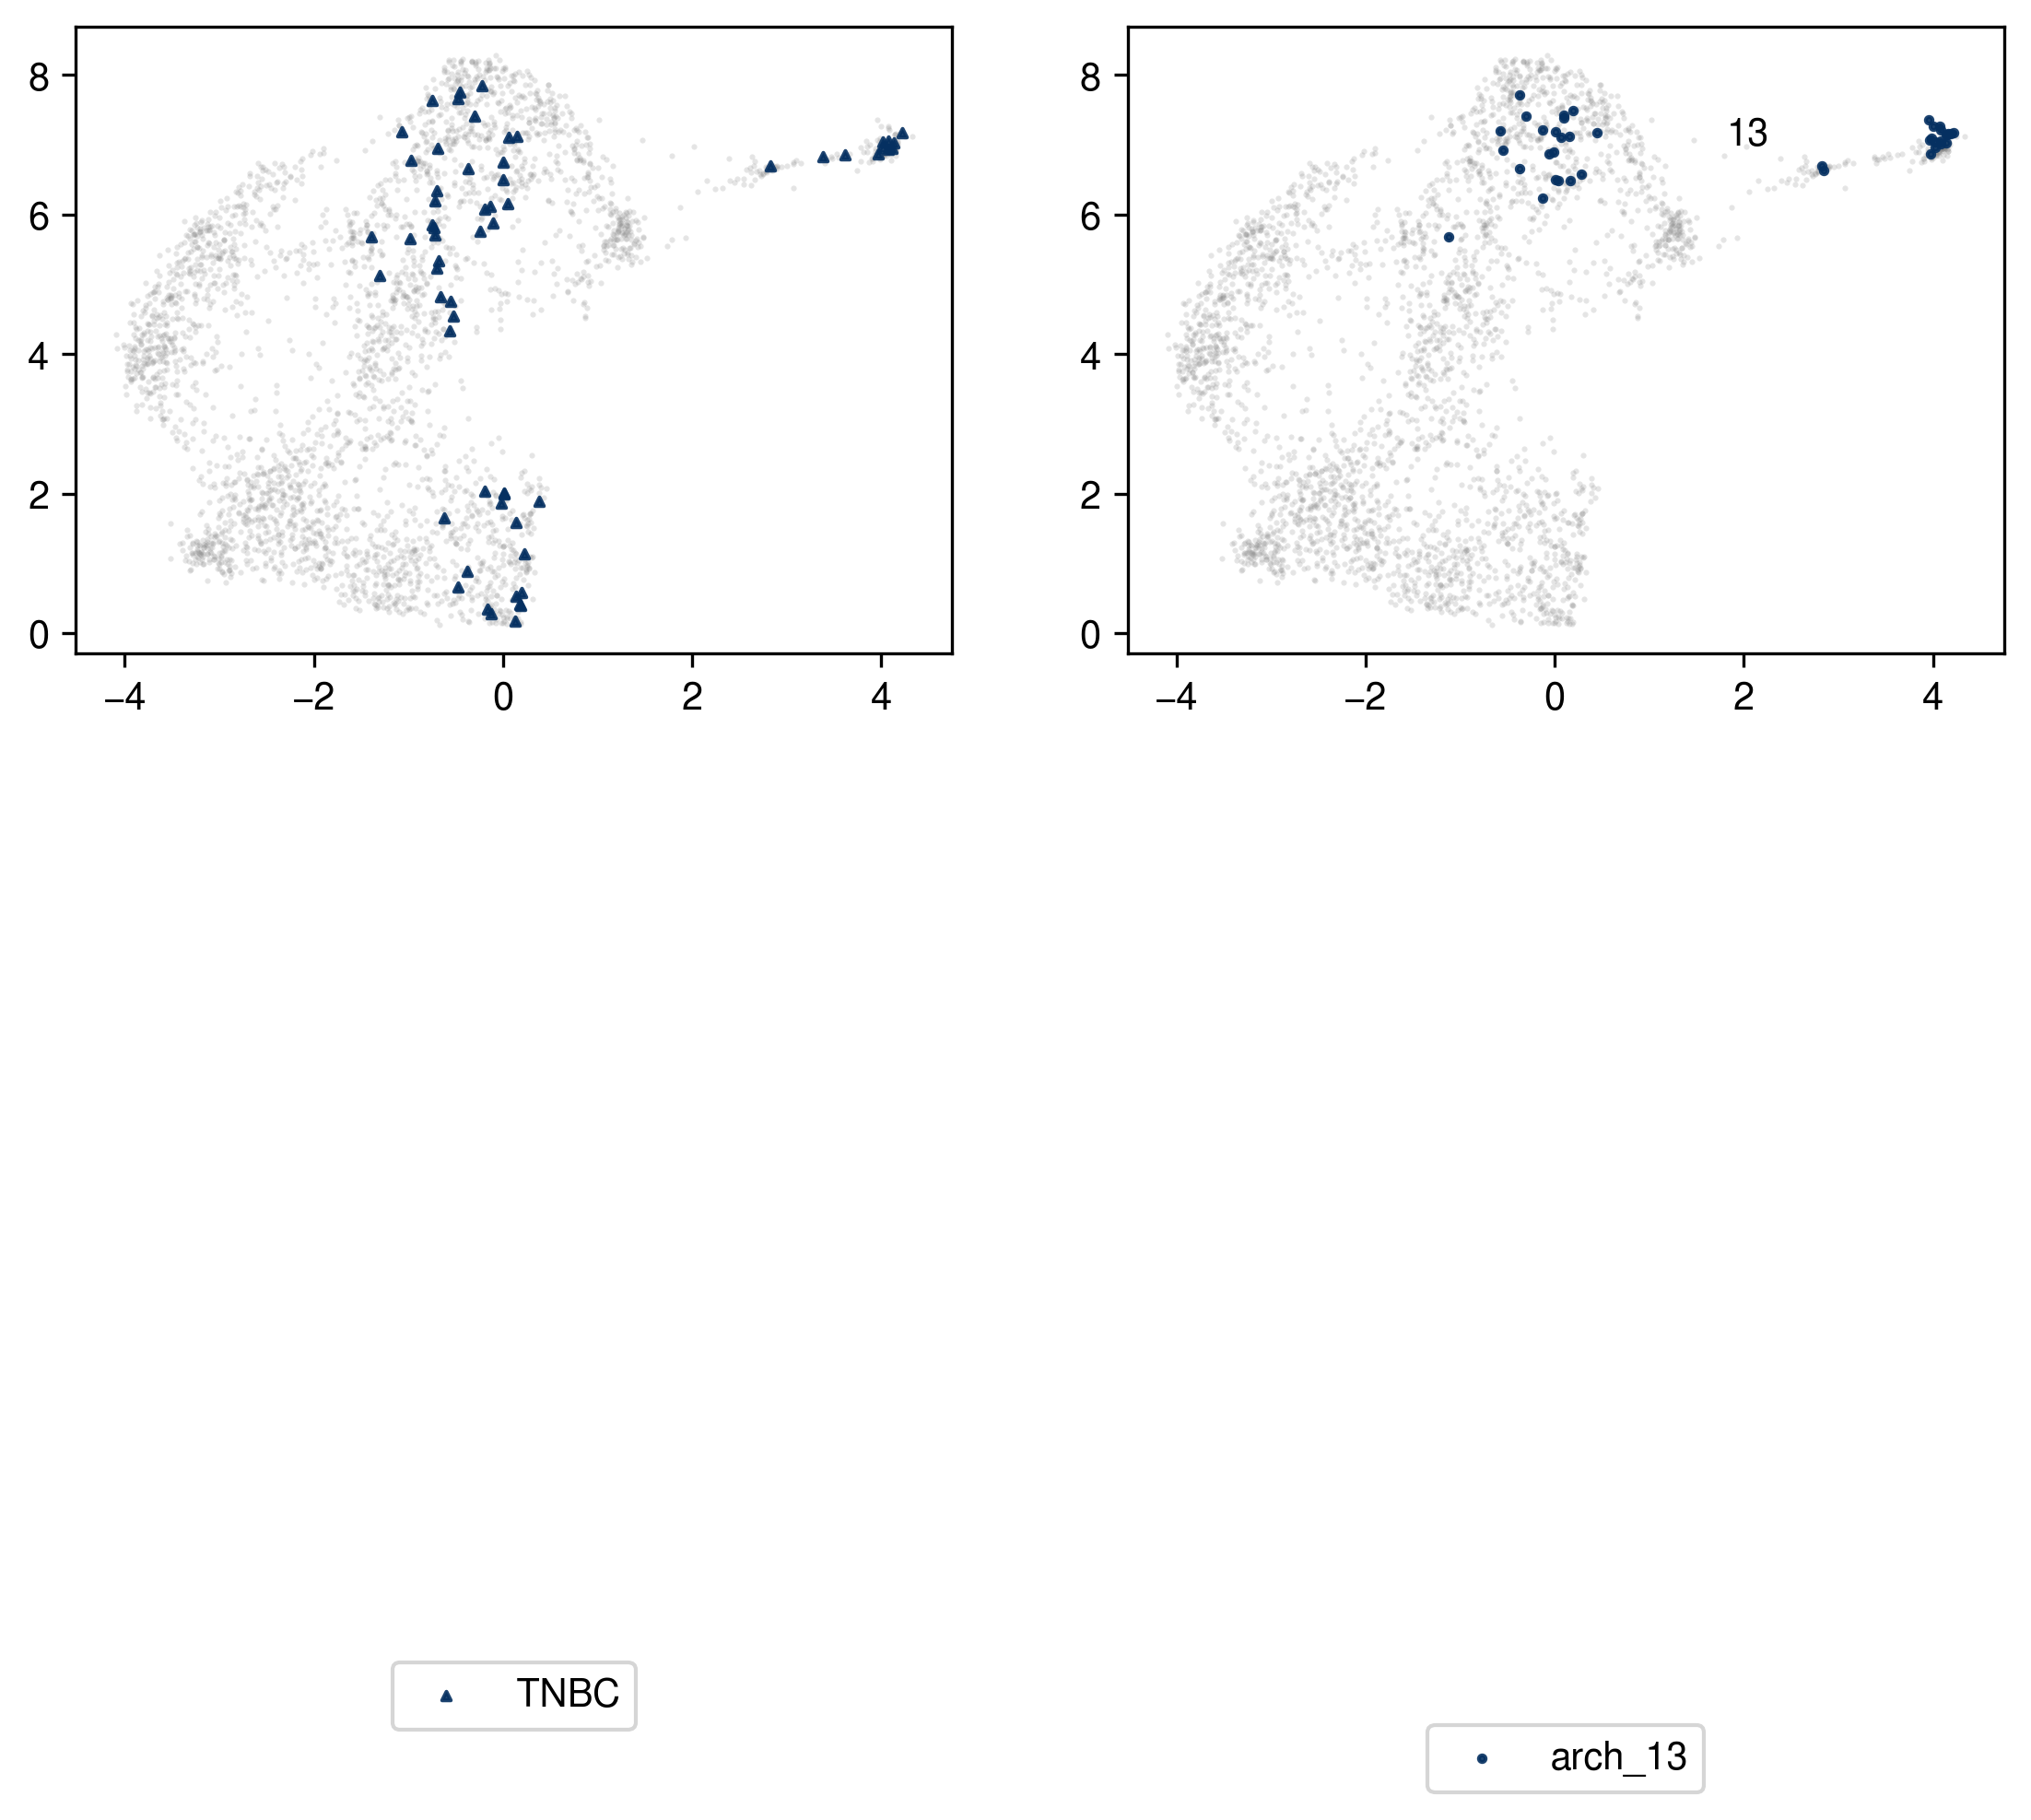

In [38]:
aa_model.plot_anchor_archetype_clusters(
    anchor_df=anchors_df,
    cell_types=['T_cells_c2_CD4+_T-regs_FOXP3'],
    arche_lbls=['arch_16']
)

aa_model.plot_anchor_archetype_clusters(
    anchor_df=anchors_df,
    cell_types=['MBC'],
    arche_lbls=['arch_5']
)

aa_model.plot_anchor_archetype_clusters(
    anchor_df=anchors_df,
    cell_types=['TNBC'],
    arche_lbls=['arch_13']
)

##### Jointly visualize tumor anchor spots & mapped archetypes


(<Figure size 2700x900 with 2 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

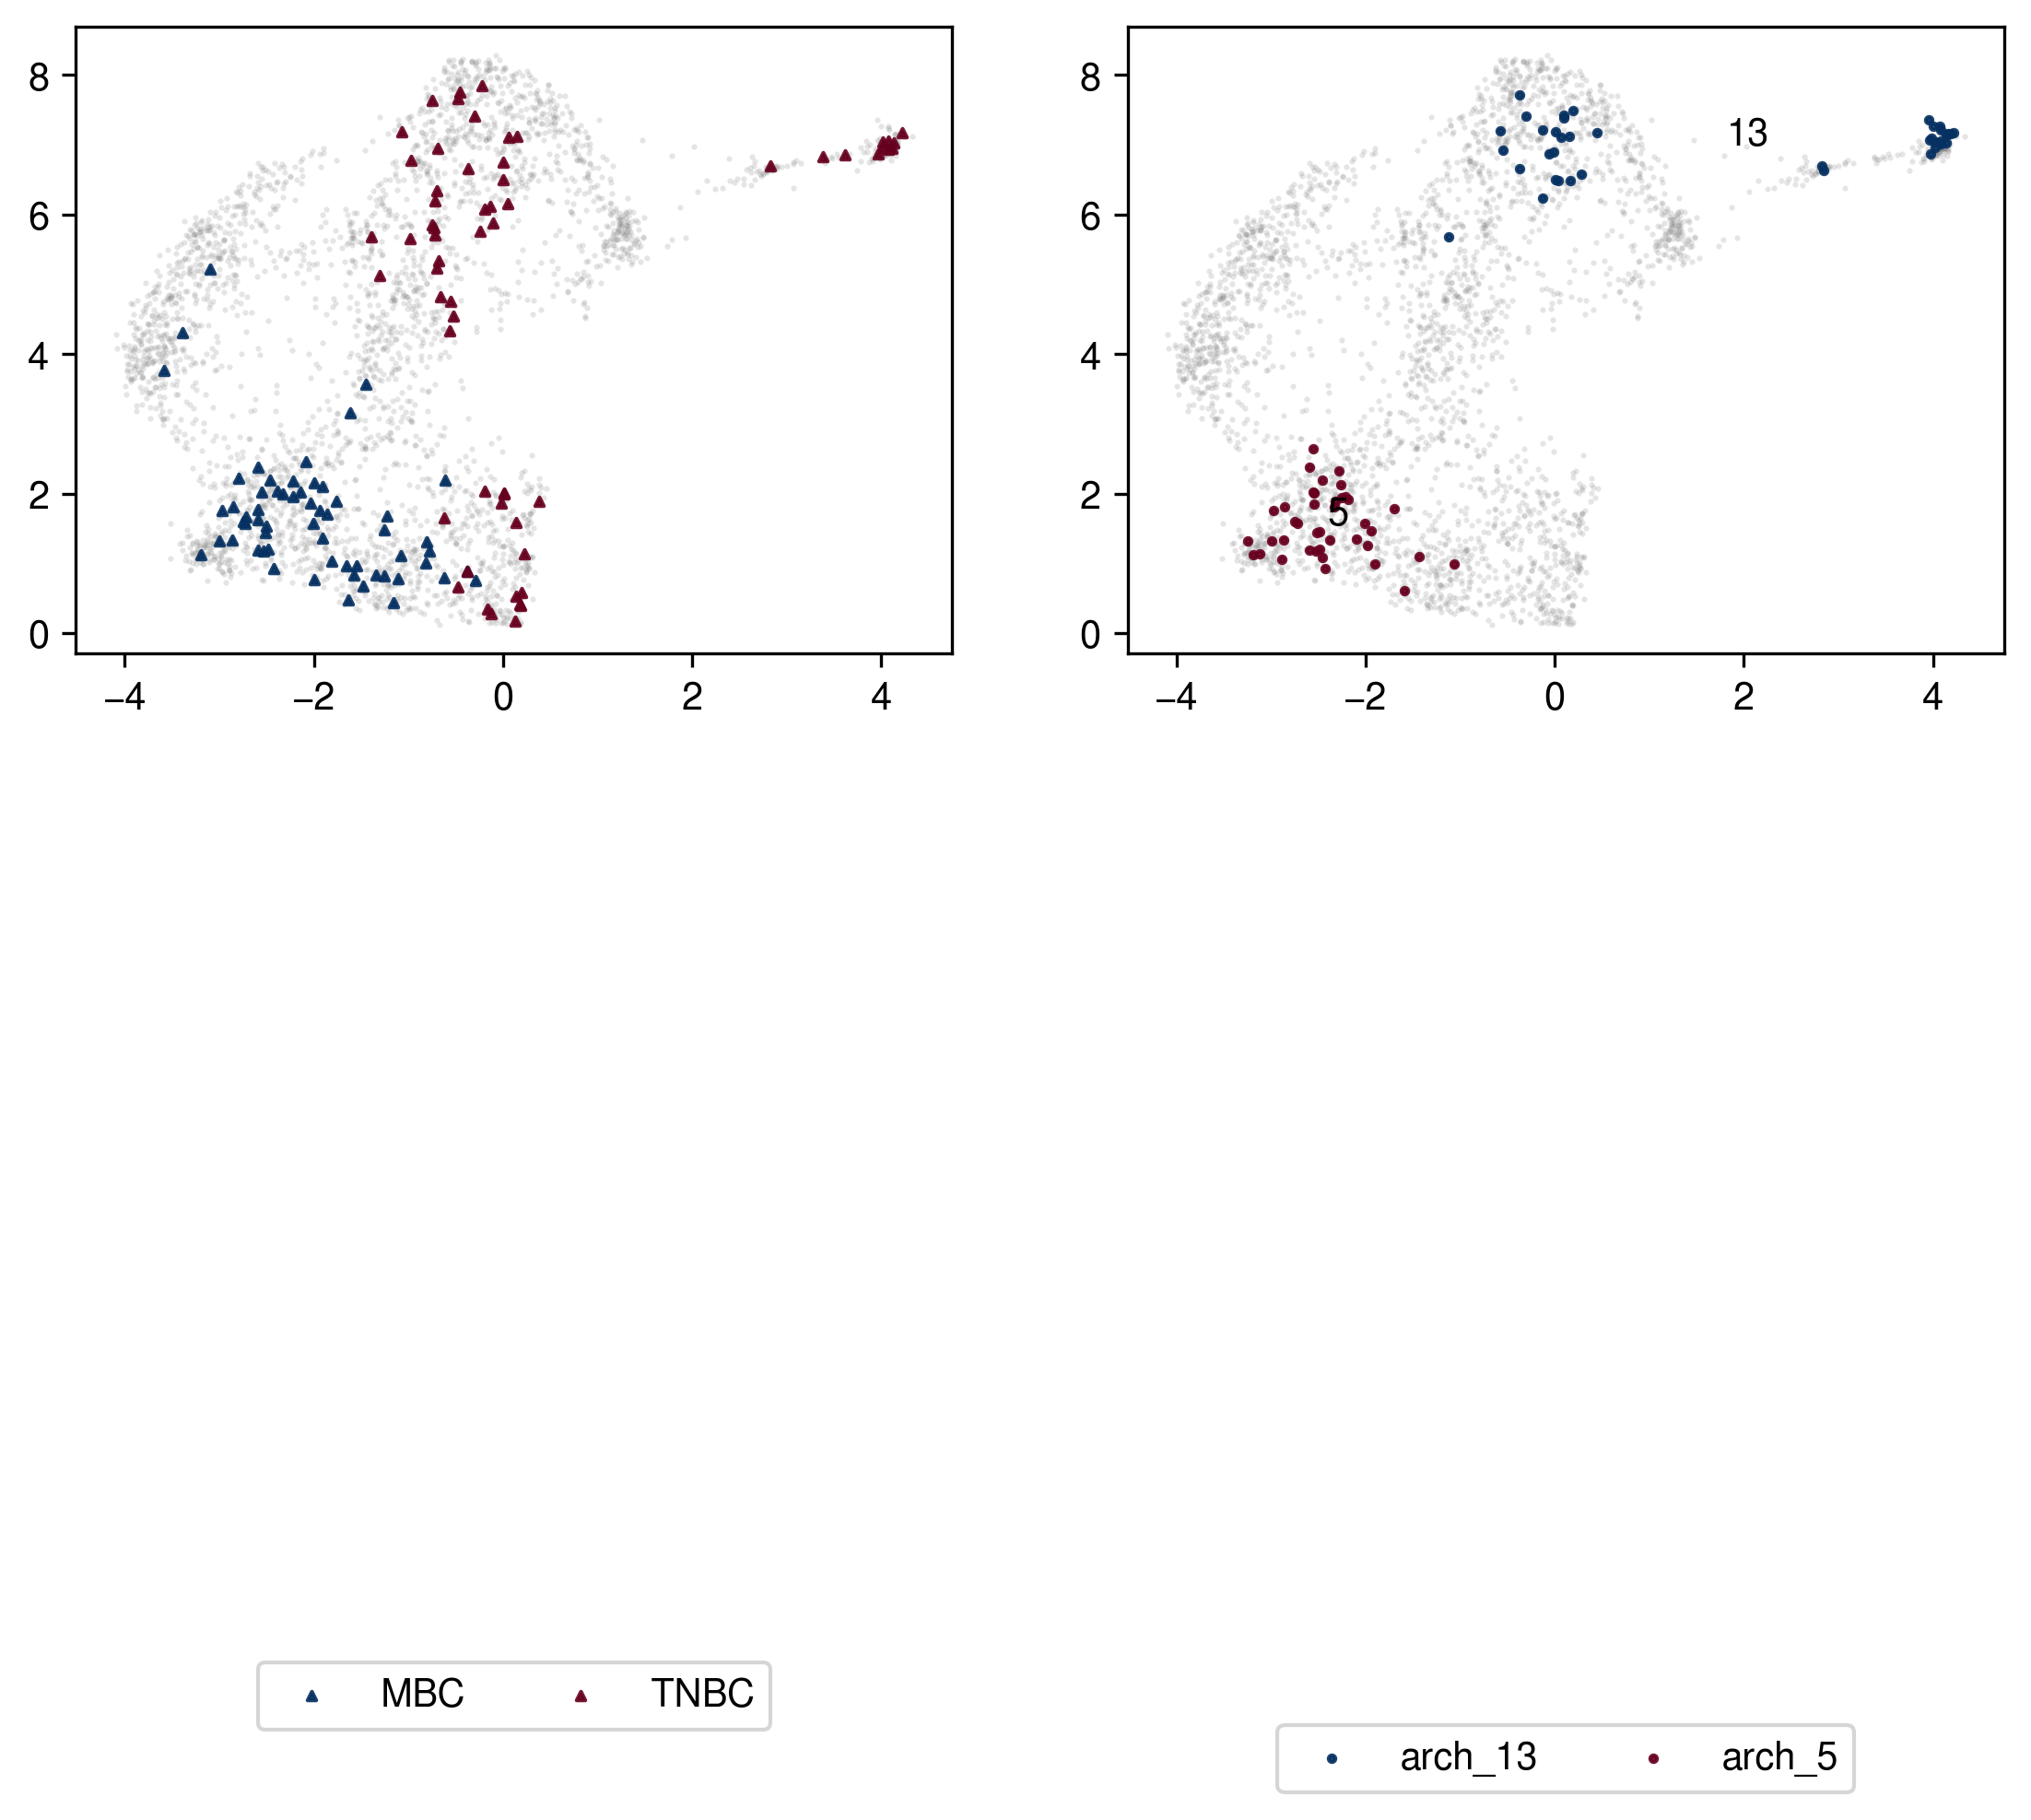

In [39]:
aa_model.plot_anchor_archetype_clusters(
    anchor_df=anchors_df,
    cell_types=['MBC', 'TNBC'],
    arche_lbls=['arch_5', 'arch_13'],
)

##### Application: appending marker genes 
Find a factor with few annotated marker genes, find the archetype(s) having high overlapping ratio with it & append archetypal marker genes to the annotated marker genes.

E.g. MBC: there'are only 17 signature genes for MBC, as opposed to 61 for TNBC which we're comparing against. We append archetypal DEGs that map to MBC markers & refine anchor spots with greater searching power.

In [56]:
from importlib import reload
reload(utils)

<module 'starfysh.utils' from '../starfysh/utils.py'>

In [41]:
map_dict['MBC']

'arch_5'

We find all archetypes that have over `30%` overlapping ratio with the original anchor spots of `MBC`:

In [46]:
map_df.loc['MBC'][map_df.loc['MBC'] >= .3]

arch_3     0.300
arch_5     0.425
arch_30    0.300
Name: MBC, dtype: float64

We append the top 15 DEGs of the aforementioned archetypes to `MBC` & re-calculate anchor spots:

In [60]:
gene_sig_mbc = gene_sig.copy()

gene_sig_mbc = utils.append_sigs(
    gene_sig=gene_sig,
    factor='MBC',
    sigs=markers_df['arch_3'],
    n_genes=30
)

gene_sig_mbc = utils.append_sigs(
    gene_sig=gene_sig,
    factor='MBC',
    sigs=markers_df['arch_5'],
    n_genes=30
)

gene_sig_mbc = utils.append_sigs(
    gene_sig=gene_sig,
    factor='MBC',
    sigs=markers_df['arch_30'],
    n_genes=30
)

In [61]:
gene_sig_mbc.apply(
    lambda cell_type: 
    (~pd.isna(cell_type)).sum()
)

T_cells_c0_CD4+_CCR7            37
T_cells_c1_CD4+_IL7R            37
T_cells_c3_CD4+_Tfh_CXCL13      34
T_cells_c2_CD4+_T-regs_FOXP3    37
B_cells_Memory                  34
B_cells_Naive                   46
NK                              33
Macrophage_M1                   65
Macrophage_M2                   61
Endothelial                     58
MDSC                             8
MBC                             44
TNBC                            61
CD8_T_cell_activation           25
CD8+_deletional_tolerance       31
CD8+_TIL_dysfunction            71
cDC                             20
pDC                             12
Terminal_exhaustion             31
Precursor_exhaustion            21
CAFs_MSC_iCAF-like              32
CAFs_myCAF-like                 31
PVL_Differentiated              31
PVL_Immature                    31
Normal_epithelial               38
Plasmablasts                    40
dtype: int64

In [62]:
visium_args = utils.VisiumArguments(adata_sample,
                                    adata_sample_normed,
                                    gene_sig_mbc,
                                    map_info,
                                    n_anchors=60,
                                    window_size=5
                                   )

[2022-08-23 15:28:35] Filtering signatures not highly variable...
[2022-08-23 15:28:35] Smoothing library size by taking averaging with neighbor spots...


	 The number of original variable genes in the dataset (2537,)
	 The number of siganture genes in the dataset (701,)
	 After filter out some genes in the signature not in the var_names ... (665,)
	 After filter out some genes not highly expressed in the signature ... (665,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537
	 The number of original variable genes in the dataset (2001,)
	 The number of siganture genes in the dataset (701,)
	 After filter out some genes in the signature not in the var_names ... (665,)
	 After filter out some genes not highly expressed in the signature ... (665,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537


[2022-08-23 15:28:36] Retrieving & normalizing signature gene expressions...
[2022-08-23 15:28:37] Identifying anchor spots (highly expression of specific cell-type signatures)...


### Run starfysh

We restart the model for `n_repeat` times, select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

<br><br>

##### Benchmark Comparison:
- Run raw starfysh without appending MBC archetypal markers
- Run starfysh after append MBC-mapped archetypal markers

#### (1). Model parameters

In [68]:
n_repeats = 3
epochs = 100
patience = 10
device = torch.device('cpu')

#### (2). Model training

In [70]:
# Raw gene sigs
visium_args = utils.VisiumArguments(adata_sample,
                                    adata_sample_normed,
                                    gene_sig_mbc,
                                    map_info,
                                    n_anchors=60,
                                    window_size=5
                                   )

# update adata
adata, adata_norm = visium_args.get_adata()

# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 patience=patience,
                                 device=device
                                )


[2022-08-23 15:59:24] Filtering signatures not highly variable...
[2022-08-23 15:59:24] Smoothing library size by taking averaging with neighbor spots...


	 The number of original variable genes in the dataset (2537,)
	 The number of siganture genes in the dataset (701,)
	 After filter out some genes in the signature not in the var_names ... (665,)
	 After filter out some genes not highly expressed in the signature ... (665,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537
	 The number of original variable genes in the dataset (2001,)
	 The number of siganture genes in the dataset (701,)
	 After filter out some genes in the signature not in the var_names ... (665,)
	 After filter out some genes not highly expressed in the signature ... (665,)
	 Combine the varibale and siganture, the total unique gene number is ... 2537


[2022-08-23 15:59:25] Retrieving & normalizing signature gene expressions...
[2022-08-23 15:59:26] Identifying anchor spots (highly expression of specific cell-type signatures)...
[2022-08-23 15:59:26] Running Starfysh with 3 restarts, choose the model with best parameters...
[2022-08-23 15:59:26]  ===  Restart Starfysh 1 === 

[2022-08-23 15:59:26] Initializing model parameters...
[2022-08-23 15:59:46] Epoch[10/100], train_loss: 2267.3133, train_reconst: 1387.9330, train_z: 19.5888,train_c: 838.8452,train_n: 20.9464
[2022-08-23 16:00:06] Epoch[20/100], train_loss: 2122.4714, train_reconst: 1340.0055, train_z: 19.4343,train_c: 744.9735,train_n: 18.0581
[2022-08-23 16:00:26] Epoch[30/100], train_loss: 2060.9986, train_reconst: 1315.2599, train_z: 19.8675,train_c: 708.9857,train_n: 16.8855
[2022-08-23 16:00:45] Epoch[40/100], train_loss: 2029.2644, train_reconst: 1298.2872, train_z: 19.7984,train_c: 695.1642,train_n: 16.0146
[2022-08-23 16:01:05] Epoch[50/100], train_loss: 1999.0683, tra

### Basic downstream analysis

Raw gene sigs:

In [ ]:
import json
from scipy import stats

In [ ]:
lib_low=torch.exp(torch.Tensor([5.0])).to(device)

inference_outputs, generative_outputs, px = starfysh.model_eval(model,
                                                                adata, 
                                                                visium_args.sig_mean,
                                                                device,
                                                                visium_args.log_lib,
                                                                lib_low
                                                               )
u = post_analysis.get_z_umap(inference_outputs)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

In [ ]:
px_0 = starfysh.model_ct_exp(model,
                             adata, 
                             visium_args.sig_mean, 
                             device,
                             visium_args.log_lib,
                             lib_low,
                             ct_idx=0)

#### (1). gene sig mean vs. inferred prop

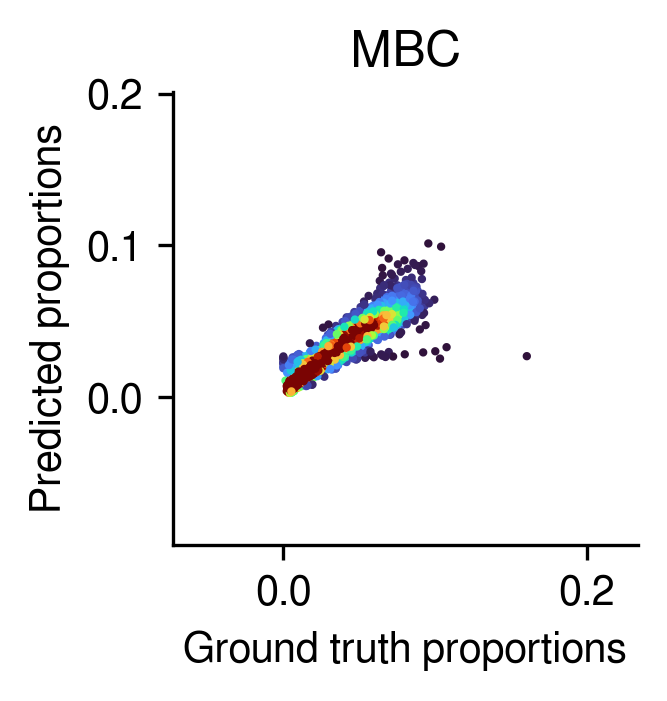

In [71]:
sig_mean_n_df = pd.DataFrame(
    np.array(visium_args.sig_mean_znorm)/(np.sum(np.array(visium_args.sig_mean_znorm),axis=1,keepdims=True)+1e-5),
    columns=visium_args.sig_mean_znorm.columns,
    index=visium_args.sig_mean_znorm.index
)

post_analysis.pred_prop_scatter(inference_outputs,
                                sig_mean_n_df,
                                idx=11
                               )

In [72]:
if data_folder =='simu_data':
    post_analysis.plot_type_all(inference_outputs,np.array(u),proportions)

In [73]:
if data_folder =='simu_data':
    post_analysis.get_corr_map(inference_outputs,sig_mean,proportions)

#### (2). inferred density

In [ ]:
plot_utils.pl_spatial_inf_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='ql_m',
                   idx=0,
                   plt_title='',
                   label='Estimated tissue density',
                   s=4,
                   #vmax=3
                   )

#### (3). inferred prop. on umap (adjust idx number for different cell types)

Cell-type: `MBC`

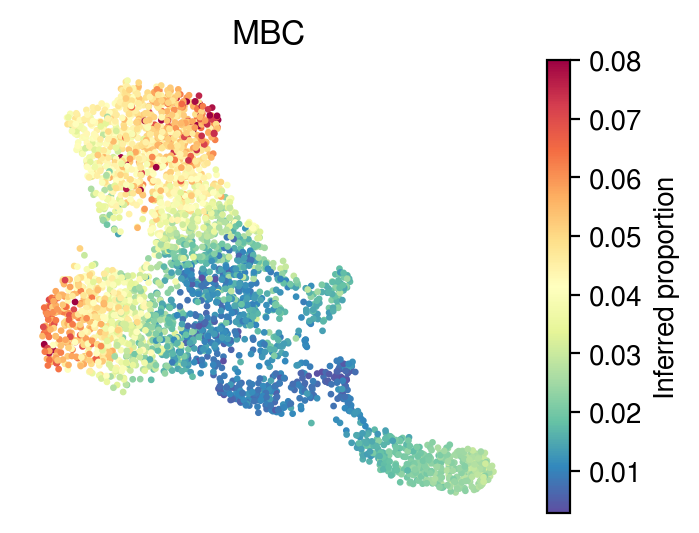

In [74]:
idx=11

plot_utils.pl_umap_feature(adata_sample,
                   u,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),#/np.sum(np.array(sig_mean),axis=1,keepdims=True),
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=2,
                   vmax=0.08
                   )

#### (4). inferred prop. on spatial loc (adjust idx number for different cell types)

*MBC*: `sig_mean` & predicted proportions

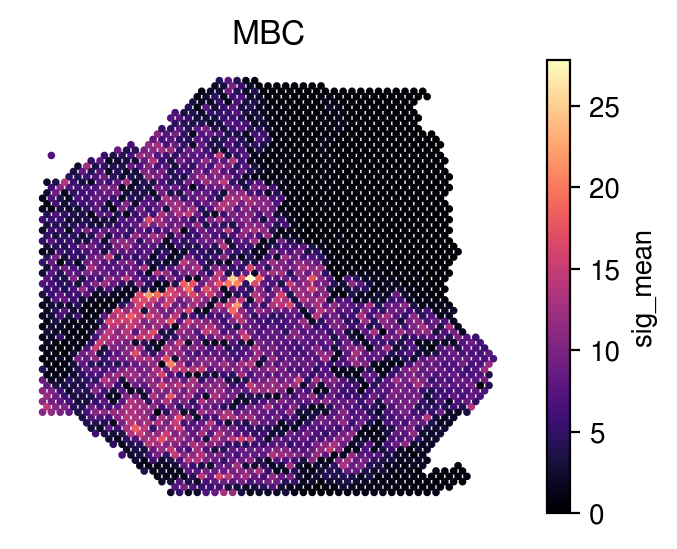

In [75]:
# sig mean
idx=11
plot_utils.pl_spatial_feature(adata,
                              map_info,
                              feature=np.array(visium_args.sig_mean),
                              idx=idx,
                              plt_title=gene_sig.columns[idx],
                              label='sig_mean',
                              s=3,
                              #vmax=5
                             )


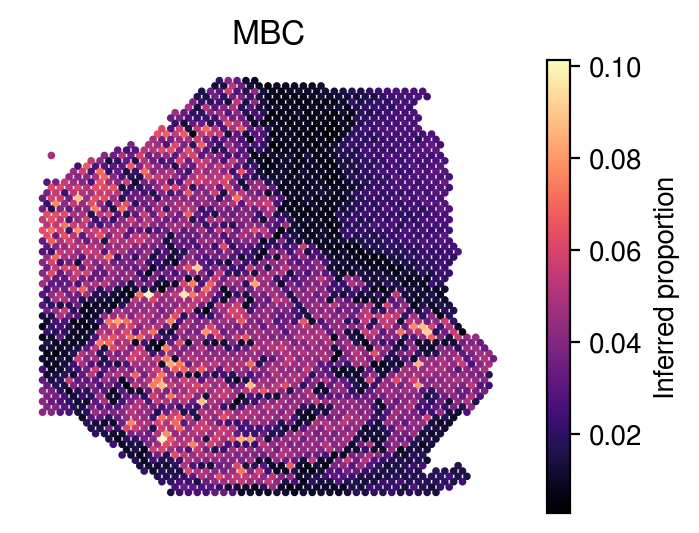

In [76]:
# predicted proportions
idx=11
plot_utils.pl_spatial_feature(adata,
                              map_info,
                              feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),
                              idx=idx,
                              plt_title=gene_sig.columns[idx],
                              label='Inferred proportion',
                              s=3,
                              #vmax=0.05
                             )

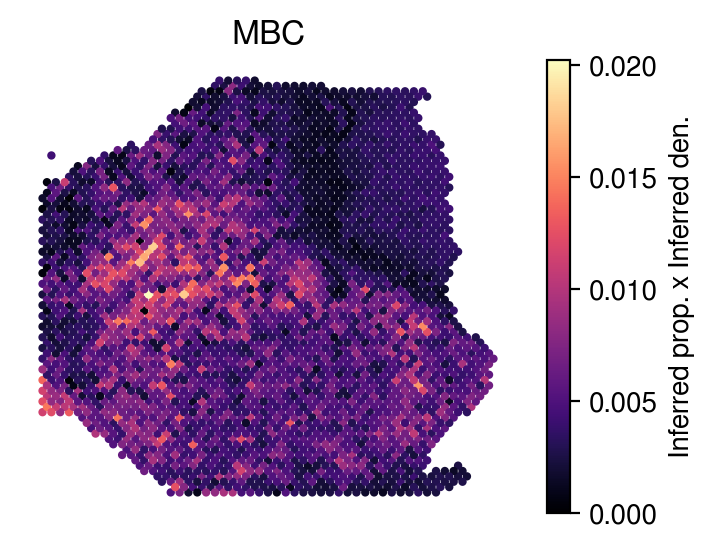

In [77]:
# Proportions * Inferred Density
idx=11
ql_m_norm = np.exp(inference_outputs['ql_m'].detach().cpu().numpy())
ql_m_norm = (ql_m_norm-ql_m_norm.min())/(ql_m_norm.max()-ql_m_norm.min())
                   
plot_utils.pl_spatial_feature(adata,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy())*ql_m_norm,
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred prop. x Inferred den.',
                   s=4,
                   #vmax=0.005
                   )

*TNBC*: `sig_mean` & predicted proportions

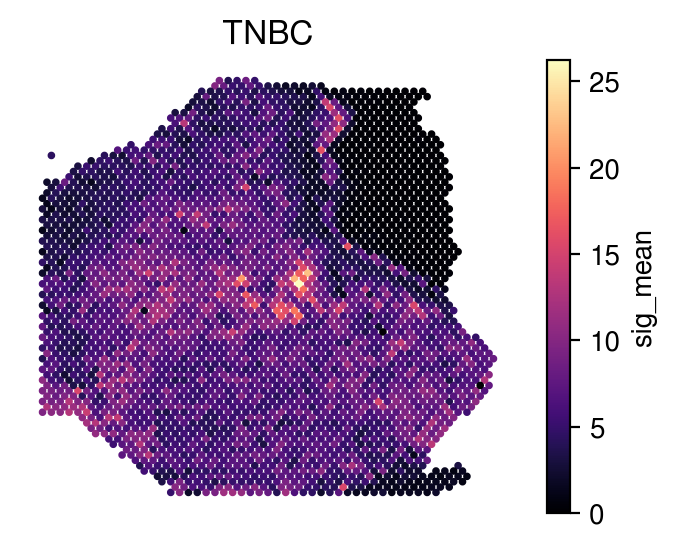

In [78]:
# sig mean
idx=12
plot_utils.pl_spatial_feature(adata,
                              map_info,
                              feature=np.array(visium_args.sig_mean),
                              idx=idx,
                              plt_title=gene_sig.columns[idx],
                              label='sig_mean',
                              s=3,
                              #vmax=5
                             )


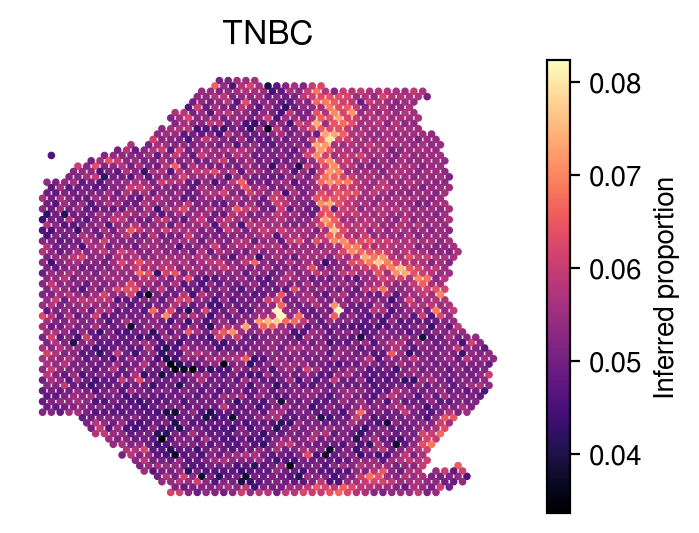

In [79]:
# predicted proportions
idx=12
plot_utils.pl_spatial_feature(adata,
                              map_info,
                              feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy()),
                              idx=idx,
                              plt_title=gene_sig.columns[idx],
                              label='Inferred proportion',
                              s=3
                             )

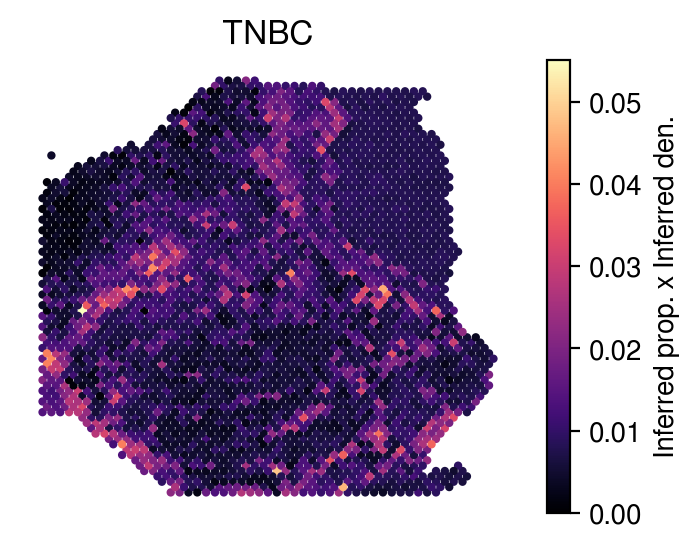

In [80]:
# Proportions * Inferred Density
idx=12
ql_m_norm = np.exp(inference_outputs['ql_m'].detach().cpu().numpy())
ql_m_norm = (ql_m_norm-ql_m_norm.min())/(ql_m_norm.max()-ql_m_norm.min())
                   
plot_utils.pl_spatial_feature(adata,
                   map_info,
                   feature=np.array(inference_outputs['qc_m'].detach().cpu().numpy())*ql_m_norm,
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred prop. x Inferred den.',
                   s=4,
                   #vmax=0.005
                   )

#### (5). Inferred cell-type specific expressions for each spots

In [83]:
pred_exp = {}
for i, label in enumerate(gene_sig.columns):
    pred_exp[label] = starfysh.model_ct_exp(model,adata_sample, 
                                            visium_args.sig_mean_znorm, 
                                            device,
                                            visium_args.log_lib,
                                            lib_low,
                                            ct_idx=i
                                           ).tolist()

Plot spot-level expression of `PDCD1` from *CD8 T cell activation*:

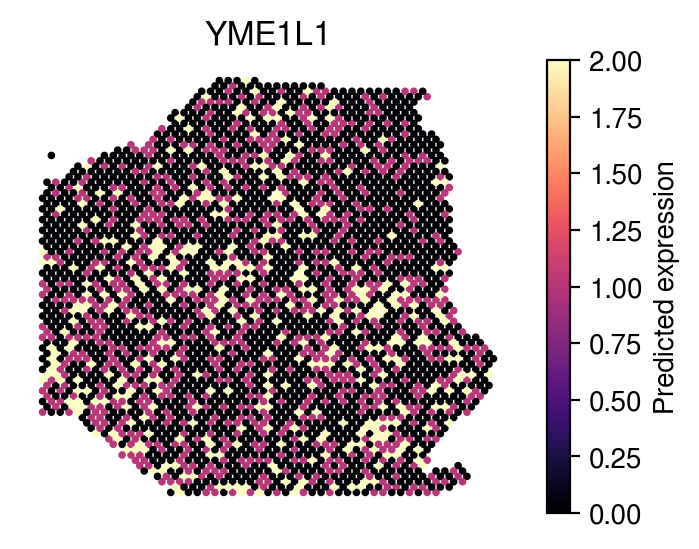

In [84]:
from scipy import stats

"""
px_0 = starfysh.model_ct_exp(model,adata_sample, 
                             sig_mean, device,log_lib,lib_low,
                             ct_idx=13
                            )
idx=list(adata_sample.var_names).index('PDCD1')
"""

plot_utils.pl_spatial_feature(adata_sample,
                   map_info,
                   feature=np.asarray(pred_exp['CD8_T_cell_activation']),
                   idx=list(adata_sample.var_names).index('PDCD1'),
                   plt_title=adata_sample.var_names[idx],
                   label='Predicted expression',
                   s=3,
                   vmax=2
                   )

#### Save inferred parameters to file

In [39]:
dist = {
        'px_rate': generative_outputs['px_rate'].detach().cpu().numpy().tolist(),
        'px_r': generative_outputs['px_r'].detach().cpu().numpy().tolist(),
        'pc_p': generative_outputs['pc_p'].detach().cpu().numpy().tolist(),

        'qc_m': inference_outputs['qc_m'].detach().cpu().numpy().tolist(),
        'qc': inference_outputs['qc'].detach().cpu().numpy().tolist(),
        'qz_m': inference_outputs['qz_m'].detach().cpu().numpy().tolist(),
        'qz_m_ct': inference_outputs['qz_m_ct'].detach().cpu().numpy().tolist(),
        'qz_logv': inference_outputs['qz_logv'].detach().cpu().numpy().tolist(),
        'qz_logv_ct': inference_outputs['qz_logv_ct'].detach().cpu().numpy().tolist(),
        'qz': inference_outputs['qz'].detach().cpu().numpy().tolist(),
        'ql_m': inference_outputs['ql_m'].detach().cpu().numpy().tolist(),
        'ql_logv': inference_outputs['ql_logv'].detach().cpu().numpy().tolist(),
        'ql': inference_outputs['ql'].detach().cpu().numpy().tolist(),
}


import json
#with open('/content/drive/MyDrive/SpatialModelProject/model_test_colab/results/02_factor/'+sample_id+'_factor.json', 'w') as fp:
with open('results/02_factor/'+sample_id+'_factor.json', 'w') as fp:

    json.dump(dist, fp)

In [41]:
with open('results/02_factor/'+sample_id+'_pred_exp.json', 'w') as fp:
    json.dump(pred_exp, fp)

---